In [1]:
from braindecode.preprocessing import (
    exponential_moving_standardize,
    preprocess,
    Preprocessor)
from numpy import multiply
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import create_windows_from_events
import torch
from braindecode.util import set_random_seeds

from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal


import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math
import wandb
import os
import neptune.new.integrations.sklearn as npt_utils
import neptune.new as neptune

from sklearn.datasets import make_swiss_roll
from braindecode.models import ShallowFBCSPNet, Deep4Net ,EEGNetv4,HybridNet,EEGInceptionMI,EEGITNet,ATCNet
os.environ['http_proxy'] = "http://192.41.170.23:3128"
os.environ['https_proxy'] = "http://192.41.170.23:3128"


def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl

def early_stopping(train_loss, validation_loss, min_delta, tolerance):
    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
          return True

def extrack_dataset(dataset):
    for x, y, window_ind in dataset:
        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    return X,np.array(y_).T

def train(model,gpu_num,train_loader,test_loader,
          weights_name=False,
          optimizer = None,
          criterion = None,
          num_epochs=500,
          vail_loader= None,
          save_weights = False,
          neptune = True
         ):

    # Train the model


    train_loss = []
    valid_loss = [10,11]
    train_accuracy = []
    valid_accuracy = []

    old_loss = 100
    old_acc = 0
    valid_loss_vail = []


    for epoch in range(num_epochs):
        iter_loss = 0.0
        correct = 0
        iterations = 0

        model.train()

        for i, (items, classes) in enumerate(train_loader):
            items = Variable(items)
            classes = classes.type(torch.LongTensor)
            classes = Variable(classes)

            if cuda.is_available():
                items = items.cuda(gpu_num)
                classes = classes.cuda(gpu_num)

            optimizer.zero_grad()
            outputs = model(items)

            loss = criterion(outputs, classes)

            iter_loss += loss.item()
            loss.backward()
            optimizer.step()

            metrics = {"train/train_loss": loss}

            #print(loss)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == classes.data).sum()
            iterations += 1

        train_loss.append(iter_loss/iterations)


        train_accuracy.append(( correct.float() / len(train_loader.dataset)))
        train_metrics = {"train/train_loss": iter_loss/iterations,
                       "train/train_accuracy": (100 * correct.float() / len(train_loader.dataset))}



        loss = 0.0
        correct = 0
        iterations = 0
        model.eval()

        for i, (items, classes) in enumerate(test_loader):
            classes = classes.type(torch.LongTensor)
            items = Variable(items)
            classes = Variable(classes)

            if cuda.is_available():
                items = items.cuda(gpu_num)
                classes = classes.cuda(gpu_num)


            outputs = model(items)
            loss += criterion(outputs, classes).item()

            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == classes.data).sum()
            #print("correct : {}".format(classes.data))
            #print("predicted : {}".format(predicted))
            iterations += 1

        valid_loss.append(loss/iterations)
        correct_scalar = np.array([correct.clone().cpu()])[0]
        valid_accuracy.append(correct_scalar / len(test_loader.dataset) )

        test_metrics = {"Test/Test_loss": loss/iterations,
                       "Test/Test_accuracy": correct_scalar / len(test_loader.dataset) }
        if save_weights is True:
            if epoch+1 > 2 and valid_loss[-1] < old_loss and old_acc <= valid_accuracy[-1] :
                    newpath = r'./{}'.format(weights_name)
                    if not os.path.exists(newpath):
                        os.makedirs(newpath)
                    torch.save(model.state_dict(),               './{}/{:.4f}_{}_{:.4f}_{:.4f}'.format(weights_name,valid_loss[-1],weights_name,valid_loss[-1],valid_accuracy[-1]))
                    old_loss = valid_loss[-1]
                    old_acc = valid_accuracy[-1]

        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                       %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        if early_stopping(train_loss[-1], valid_loss[-1], min_delta=10, tolerance = 20):
            print("We are at epoch:", epoch+1)
            run[f"epoch/valid_accuracy"].append(valid_accuracy[-1])
            run[f"epoch/train_accuracy"].append(train_accuracy[-1])
            run[f"epoch/train_loss"].append(train_loss[-1])
            run[f"epoch/valid_loss"].append(valid_loss[-1])

            break
        if neptune is True:
            run[f"epoch/valid_accuracy"].append(valid_accuracy[-1])
            run[f"epoch/train_accuracy"].append(train_accuracy[-1])
            run[f"epoch/train_loss"].append(train_loss[-1])
            run[f"epoch/valid_loss"].append(valid_loss[-1])


    return train_loss,valid_loss,train_accuracy,valid_accuracy
def eval(model,
         gpu_num,
          vail_loader= None,
         labels=None,
         ):
    model.eval()
    y_pred = []
    y_true = []
    correct=0
    for i, (items, classes) in enumerate(vail_loader):
        classes = classes.type(torch.LongTensor)
        items = Variable(items)
        classes = Variable(classes)
        if cuda.is_available():
            items = items.cuda(gpu_num)
            classes = classes.cuda(gpu_num)

        outputs = model(items)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted.clone().cpu().numpy())
        y_true.append(classes.data.clone().cpu().numpy())
        correct += (predicted == classes.data).sum()
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) )

    confusion_mat = confusion_matrix(np.array(y_true).T,np.array(y_pred).T )
    run["confusion matrices subject_id : {0}".format(subject_id)].upload(plot_confusion_matrix(confusion_mat, class_names=labels,rotate_row_labels=0,rotate_col_labels=90,with_f1_score=True))
    return y_pred,y_true,correct_scalar,valid_accuracy

In [2]:
subjects = list(range(1,10))

low_cut_hz = .5  # low cut frequency for filtering
high_cut_hz = 100.0  # high cut frequency for filtering
# Parameters for exponential moving standardization
#factor_new = 1e-3
#init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6
preprocessors = [
                    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
                    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
                    #Preprocessor('resample', sfreq=128),
                   # Preprocessor("filter", l_freq=low_cut_hz, h_freq=high_cut_hz)
                    ]
n_epochs = 5000


/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


In [3]:
from moabb.datasets import BNCI2014001
from moabb.paradigms import MotorImagery

In [4]:
dataset_name="BNCI2014001"
dataset = MOABBDataset(dataset_name=dataset_name, subject_ids= [1])
preprocess(dataset, preprocessors)
trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
print(sfreq)
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)
splitted = windows_dataset.split('session')
train_set = splitted['session_T']
valid_set = splitted['session_E']
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]
X_train,y_train = extrack_dataset(train_set)
X_valid,y_valid = extrack_dataset(valid_set)

48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
250.0
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annota

In [5]:
y = list(range(0,X_train.shape[2]))
y = np.array(y)
y.shape

(1125,)

In [6]:
X_train[0][7].shape

(1125,)

In [7]:
datas = np.stack((y,X_train[0][7]))
datas.shape

(2, 1125)

In [8]:
def sample_batch(size, noise=0.3):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0
# Plot it
data = sample_batch(10**4).T
data.shape

(2, 10000)

In [9]:
dataset = torch.tensor(datas.T).float()

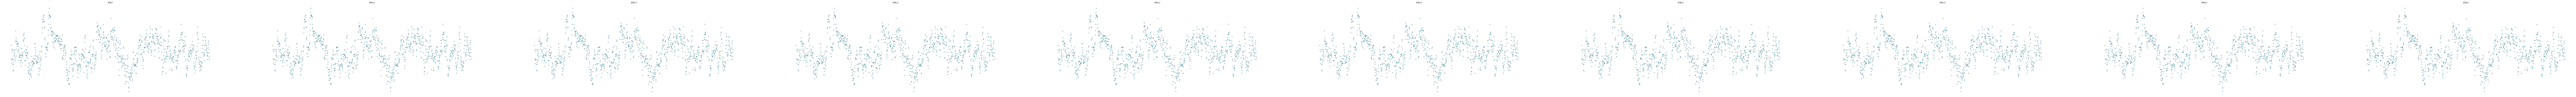

In [14]:
n_steps = 1000
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)





# Create schedule
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
# Fixed computation of variables for all timesteps
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
# Sampling function
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)
def plot_diffusion():
    fig, axs = plt.subplots(1, 10, figsize=(280, 10))
    for i in range(10):
        q_i = q_sample(dataset, torch.tensor([i * 10]))
        axs[i].scatter(q_i[:, 0], q_i[:, 1], s=10);
        axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')
plot_diffusion()

In [66]:
X_o1=X_train[1][7].tolist()

In [67]:
len(X_o1)


1125

In [18]:
X_o1=X_train[:288][7][0,250].tolist()

In [19]:
X_o1 = []
for i in range(288):
    X_o1.append(X_train[i][7][0:250].tolist())

In [20]:
len(X_o1[0])

250

In [21]:
import torch.nn.functional as F
n_steps = 100
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 4)

    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)
model = ConditionalModel(n_steps)

def p_mean_variance(model, x, t):
    # Go through model
    out = model(x, t)
    # Extract the mean and variance
    mean, log_var = torch.split(out, 2, dim=-1)
    var = torch.exp(log_var)
    return mean, log_var

In [22]:
def p_sample(model, x, t):
    mean, log_var = p_mean_variance(model, x, torch.tensor(t))
    noise = torch.randn_like(x)
    shape = [x.shape[0]] + [1] * (x.ndimension() - 1)
    nonzero_mask = (1 - (t == 0))
    sample = mean + torch.exp(0.5 * log_var) * noise
    return (sample)
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

In [23]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl
def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))
def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

In [24]:
def loss_variational(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the KL loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)
    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)
    # At the first timestep return the decoder NLL, otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    return output.mean(-1)

In [25]:
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 2)

    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)

def p_sample(model, x, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

In [26]:
def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

In [27]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

In [31]:
ema = EMA(0.9)
ema.register(model)


tensor(75.2374, grad_fn=<MeanBackward0>)
tensor(1.0270, grad_fn=<MeanBackward0>)
tensor(1.0541, grad_fn=<MeanBackward0>)
tensor(1.0721, grad_fn=<MeanBackward0>)
tensor(1.0087, grad_fn=<MeanBackward0>)
tensor(0.9776, grad_fn=<MeanBackward0>)
tensor(0.9755, grad_fn=<MeanBackward0>)
tensor(1.0015, grad_fn=<MeanBackward0>)
tensor(0.9968, grad_fn=<MeanBackward0>)
tensor(0.9649, grad_fn=<MeanBackward0>)
tensor(1.0282, grad_fn=<MeanBackward0>)
tensor(0.9880, grad_fn=<MeanBackward0>)
tensor(0.9901, grad_fn=<MeanBackward0>)
tensor(0.9939, grad_fn=<MeanBackward0>)
tensor(0.9898, grad_fn=<MeanBackward0>)
tensor(1.0267, grad_fn=<MeanBackward0>)
tensor(1.0758, grad_fn=<MeanBackward0>)
tensor(0.9883, grad_fn=<MeanBackward0>)
tensor(1.0126, grad_fn=<MeanBackward0>)
tensor(1.0196, grad_fn=<MeanBackward0>)
tensor(1.0427, grad_fn=<MeanBackward0>)


/tmp/ipykernel_266426/1622534107.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 10, figsize=(28, 3))


tensor(0.9518, grad_fn=<MeanBackward0>)
tensor(1.0162, grad_fn=<MeanBackward0>)
tensor(0.9746, grad_fn=<MeanBackward0>)
tensor(1.0205, grad_fn=<MeanBackward0>)
tensor(0.9349, grad_fn=<MeanBackward0>)
tensor(0.9884, grad_fn=<MeanBackward0>)
tensor(0.9703, grad_fn=<MeanBackward0>)
tensor(1.0436, grad_fn=<MeanBackward0>)
tensor(0.9999, grad_fn=<MeanBackward0>)
tensor(1.0225, grad_fn=<MeanBackward0>)
tensor(0.9961, grad_fn=<MeanBackward0>)
tensor(0.9713, grad_fn=<MeanBackward0>)
tensor(0.9788, grad_fn=<MeanBackward0>)
tensor(1.0288, grad_fn=<MeanBackward0>)
tensor(0.9603, grad_fn=<MeanBackward0>)
tensor(0.9747, grad_fn=<MeanBackward0>)
tensor(0.9818, grad_fn=<MeanBackward0>)
tensor(1.0131, grad_fn=<MeanBackward0>)
tensor(0.9393, grad_fn=<MeanBackward0>)
tensor(0.9750, grad_fn=<MeanBackward0>)
tensor(1.0103, grad_fn=<MeanBackward0>)
tensor(1.0402, grad_fn=<MeanBackward0>)
tensor(0.9989, grad_fn=<MeanBackward0>)
tensor(1.0226, grad_fn=<MeanBackward0>)
tensor(1.0012, grad_fn=<MeanBackward0>)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


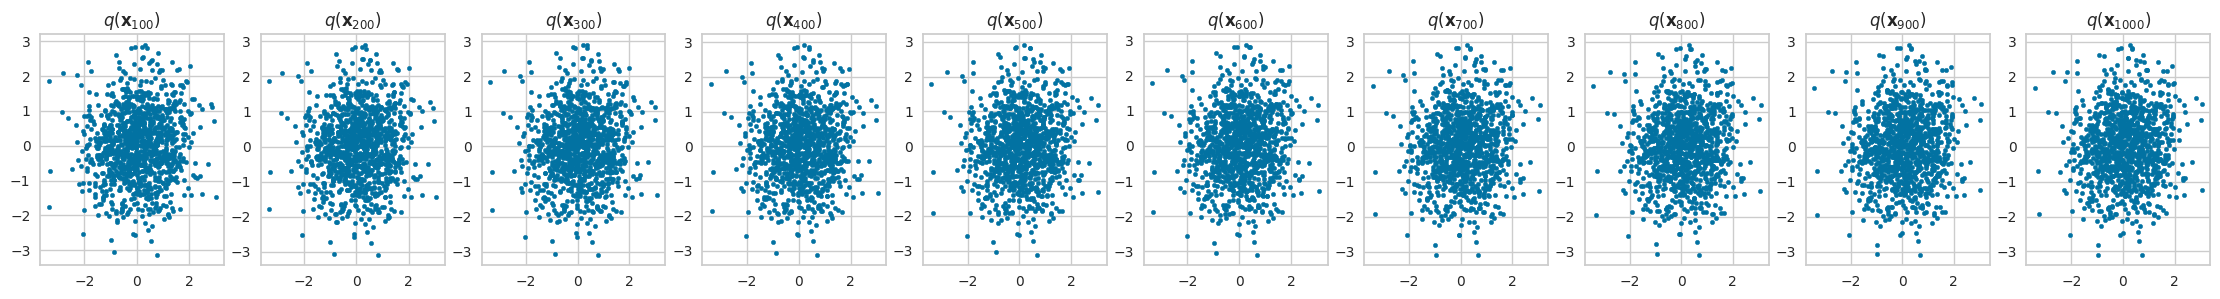

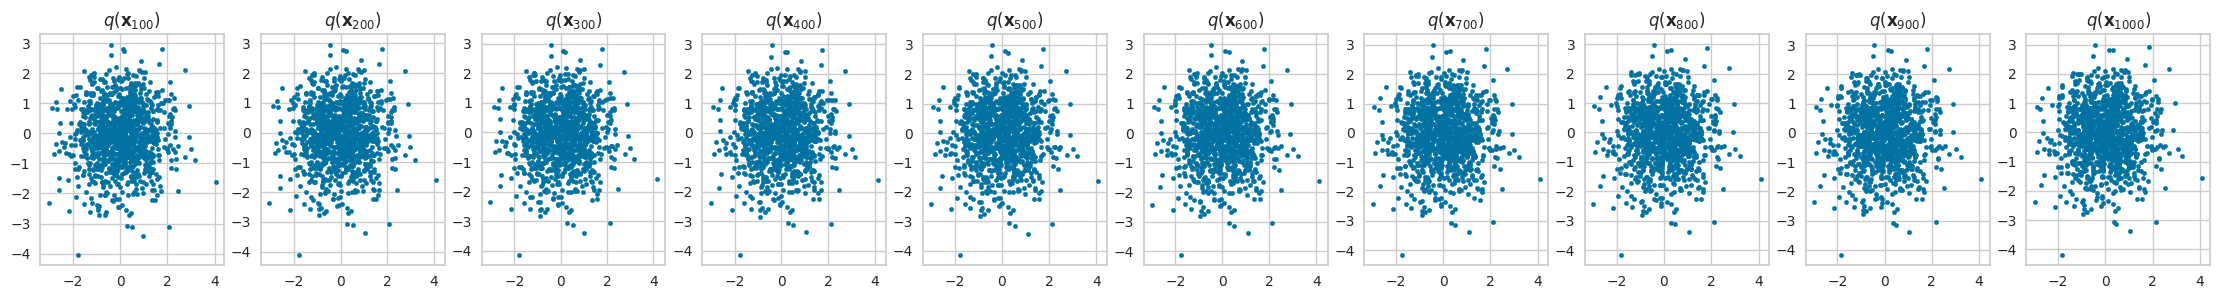

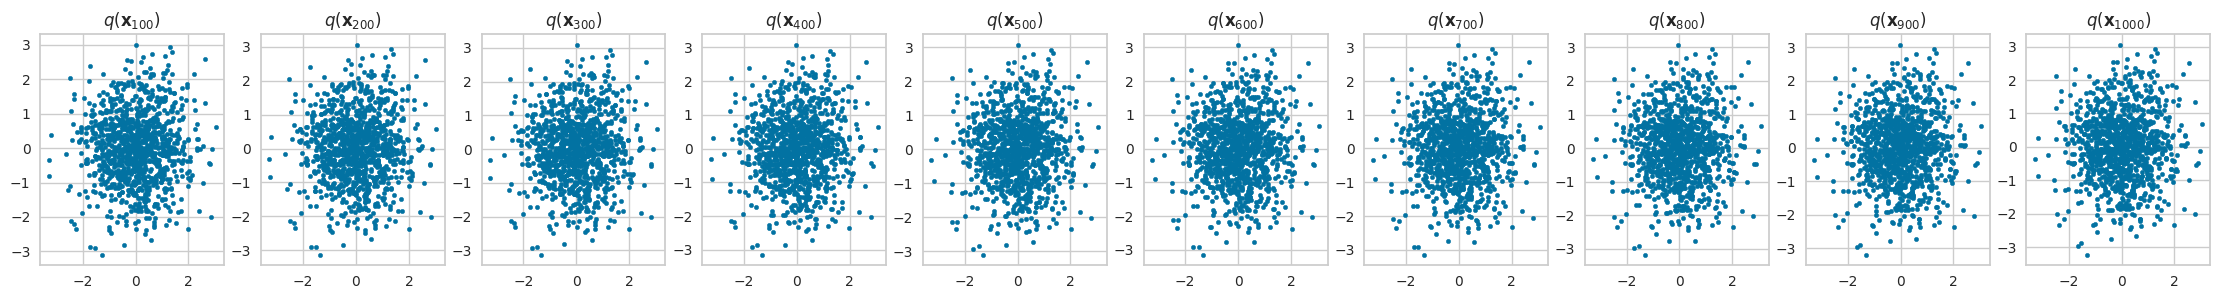

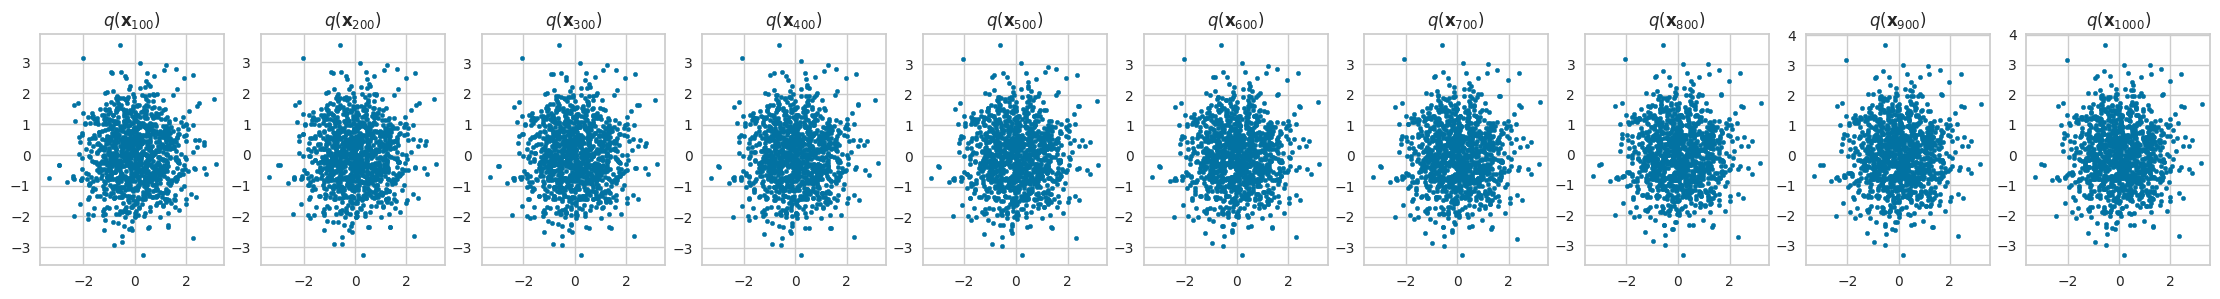

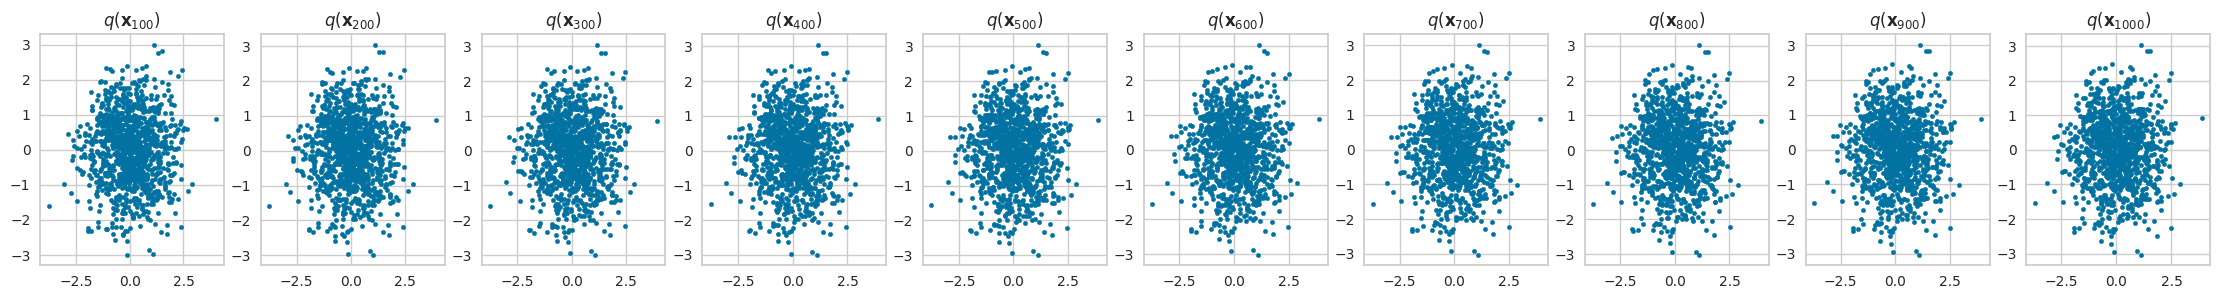

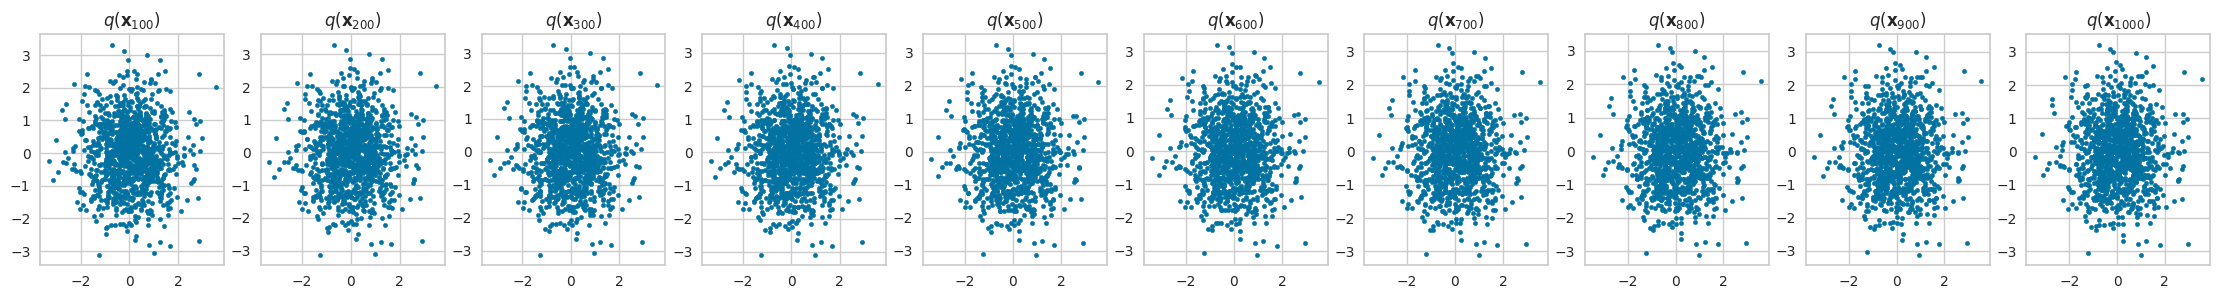

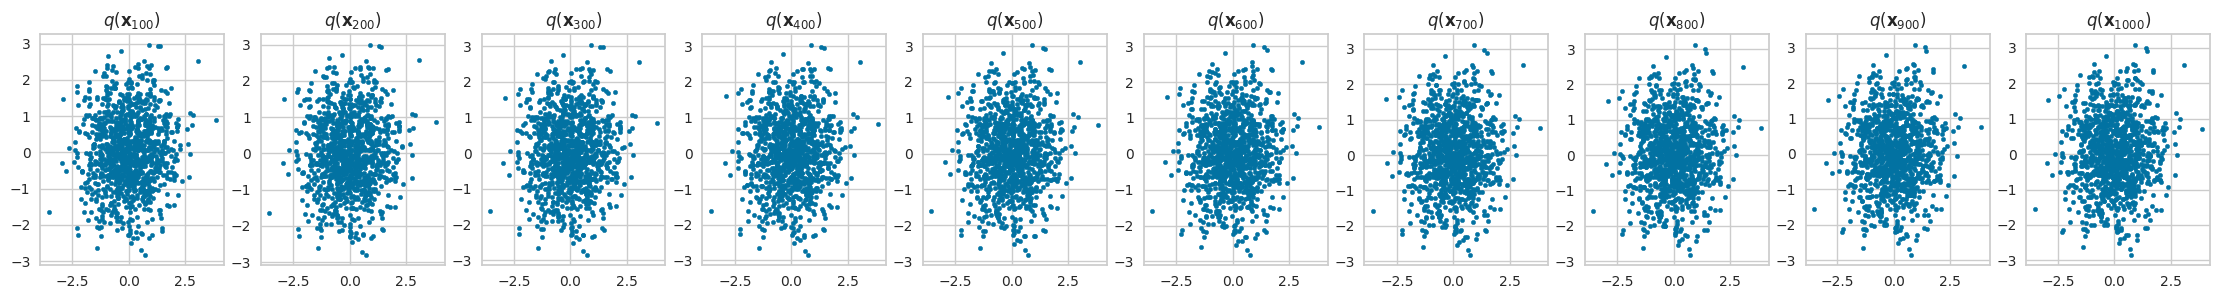

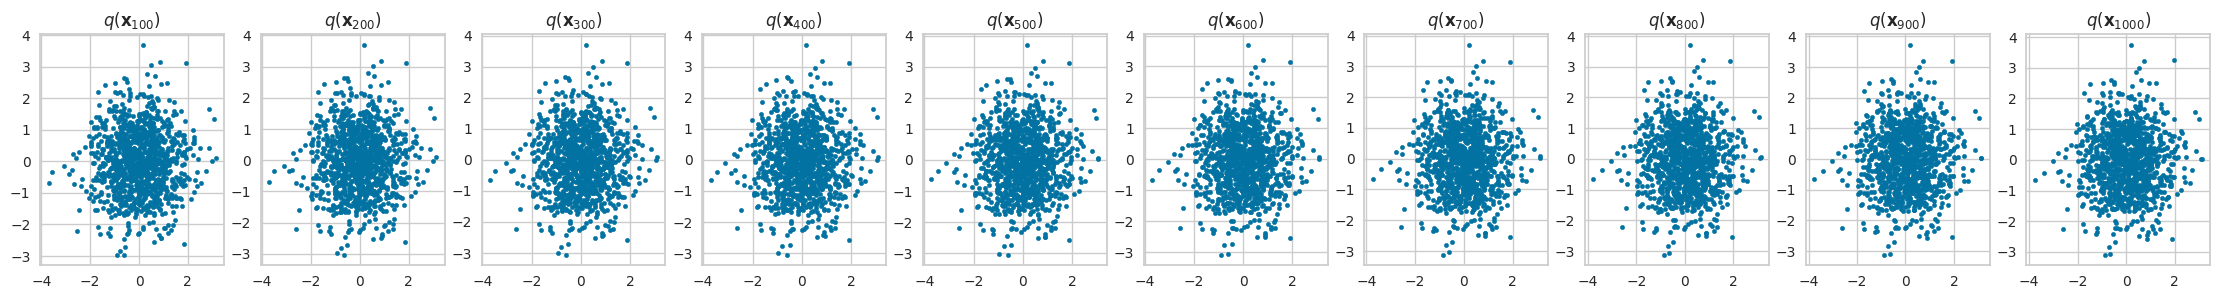

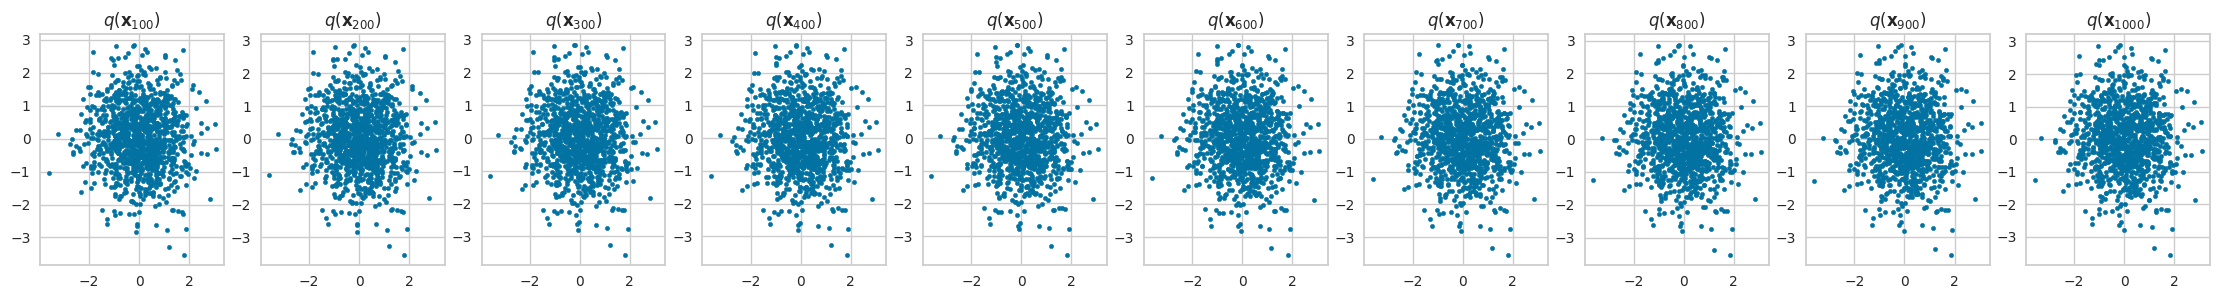

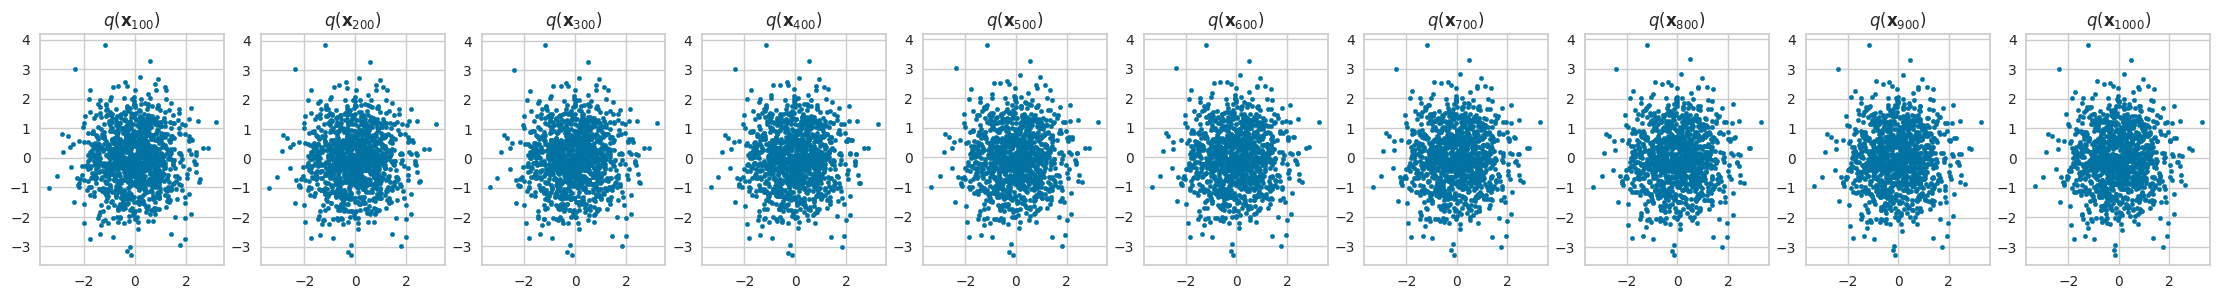

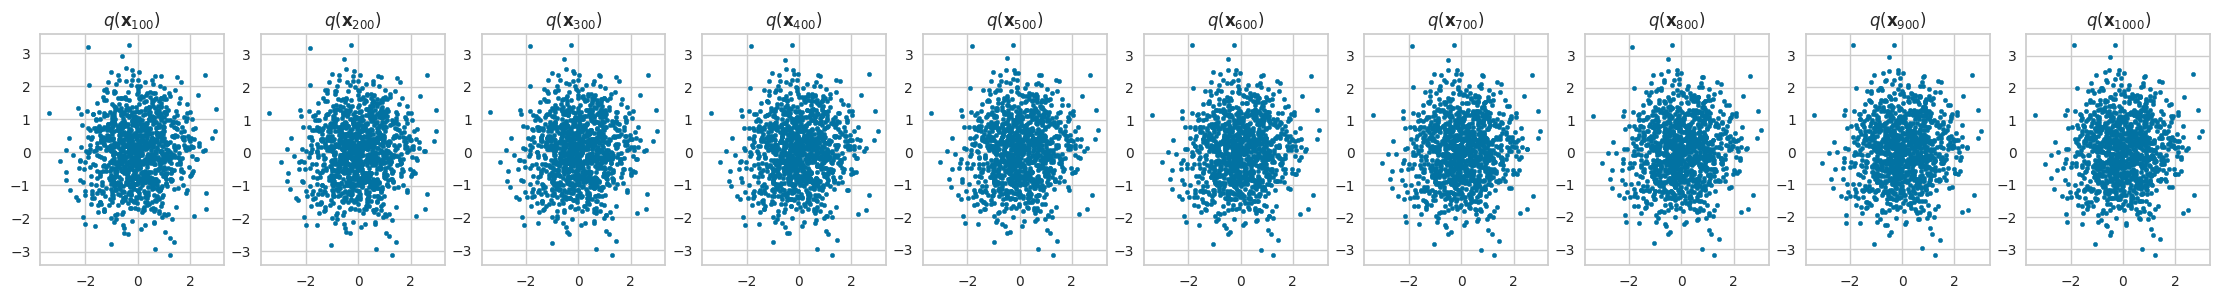

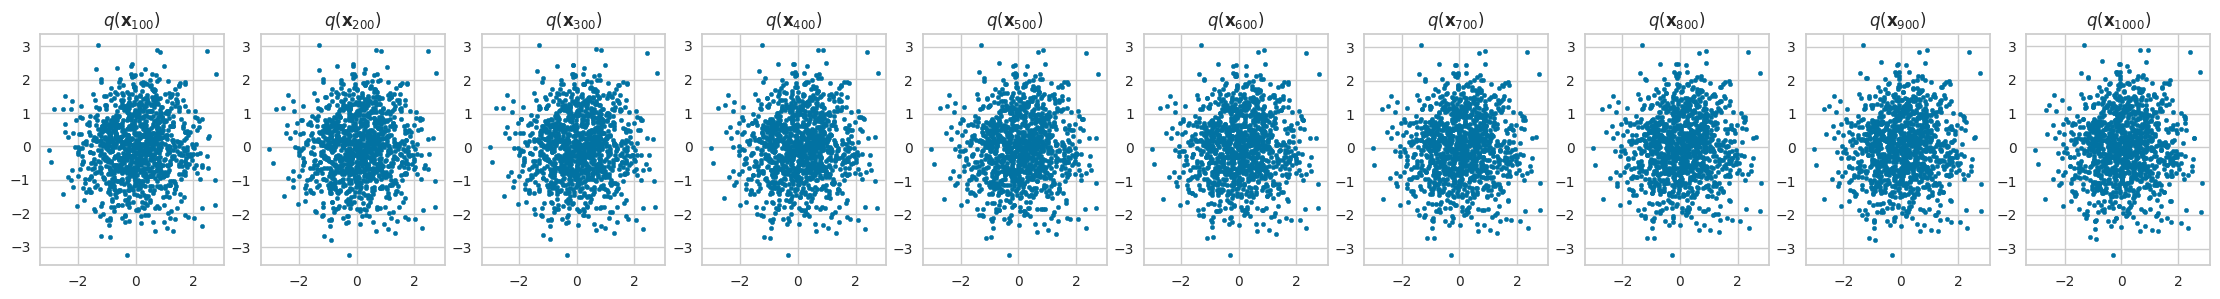

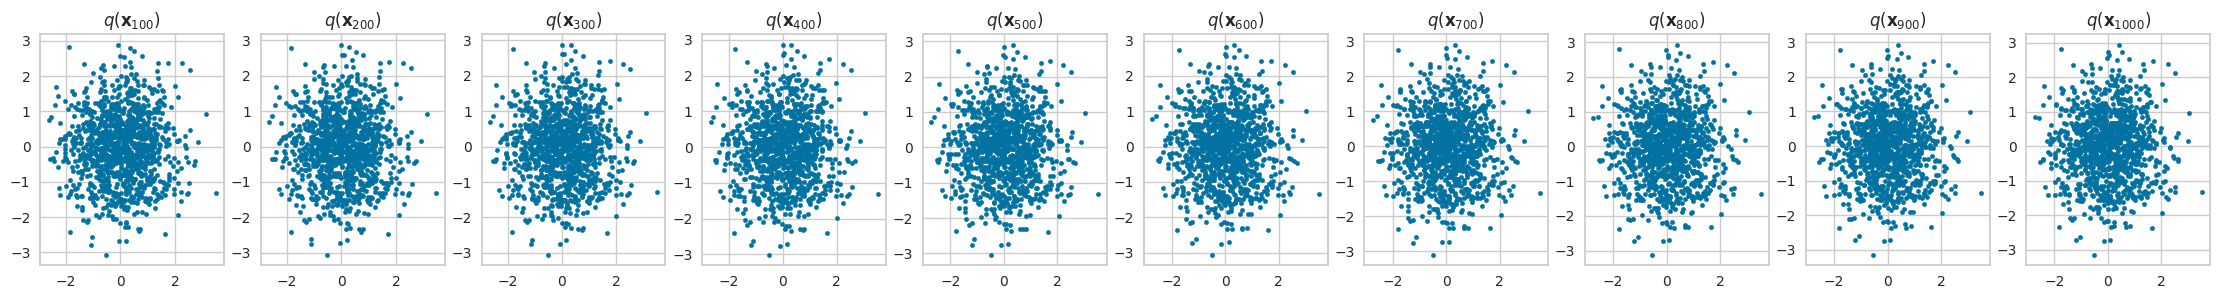

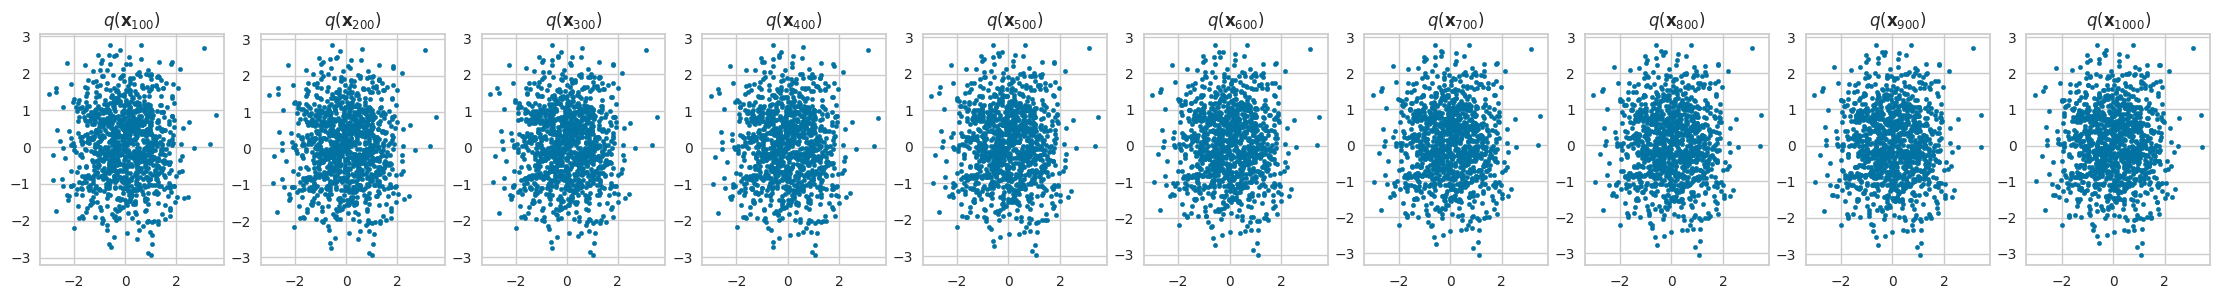

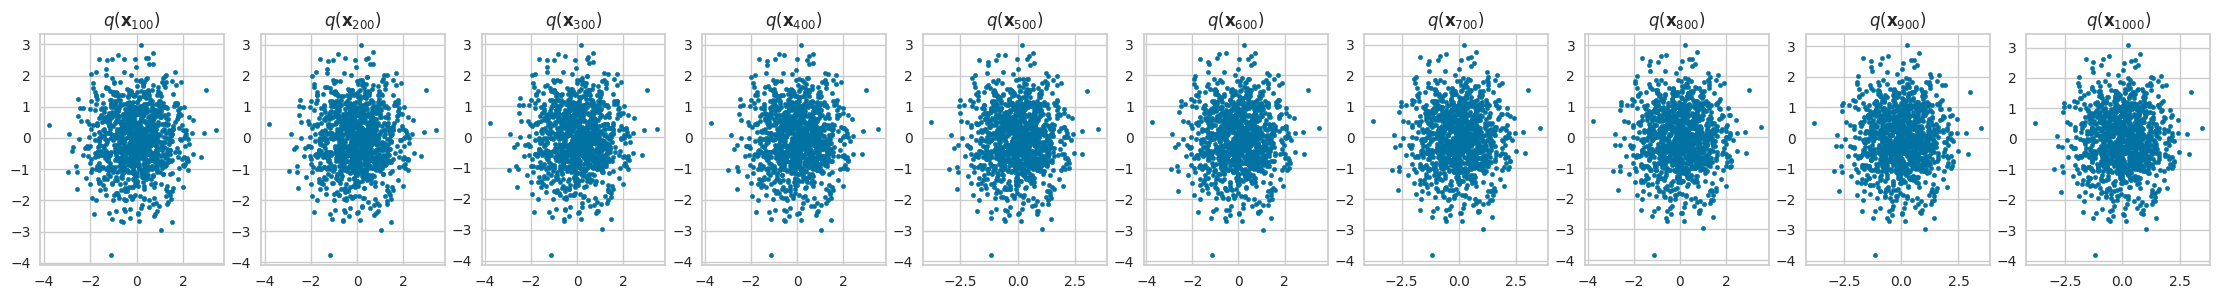

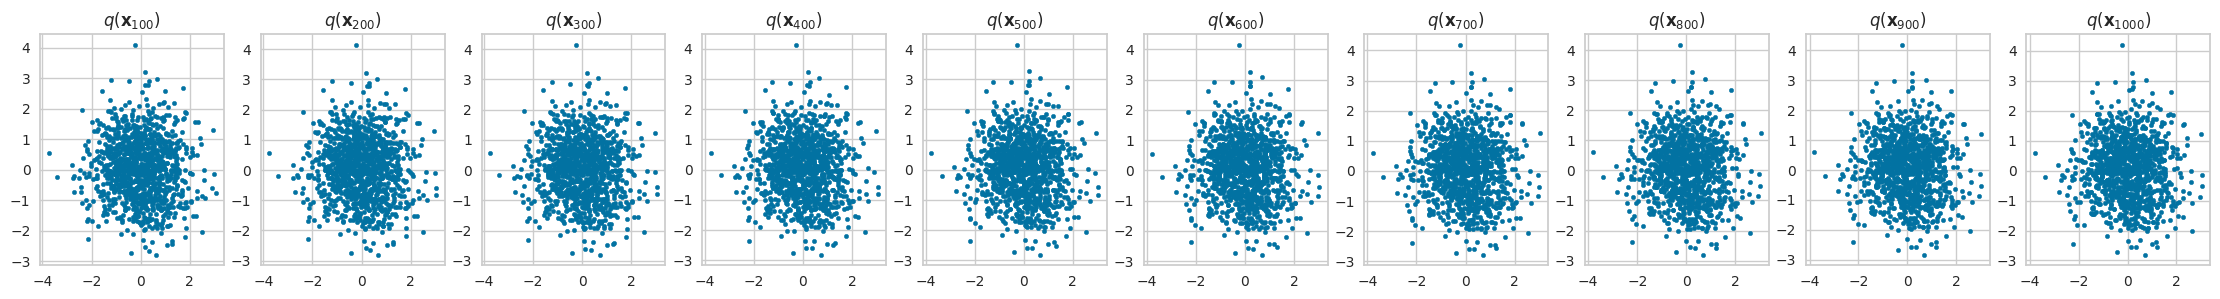

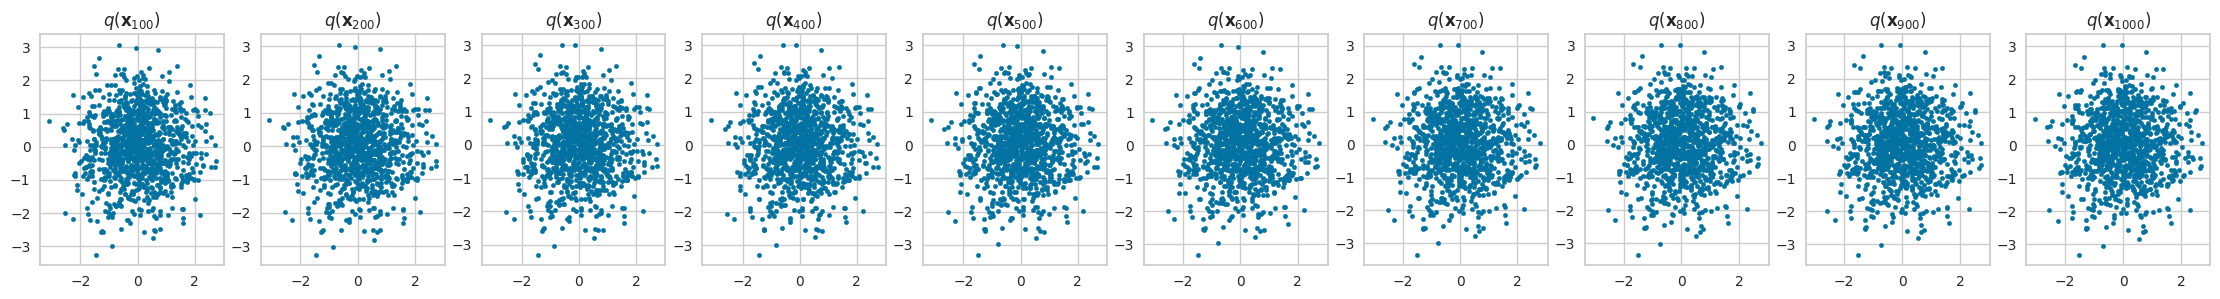

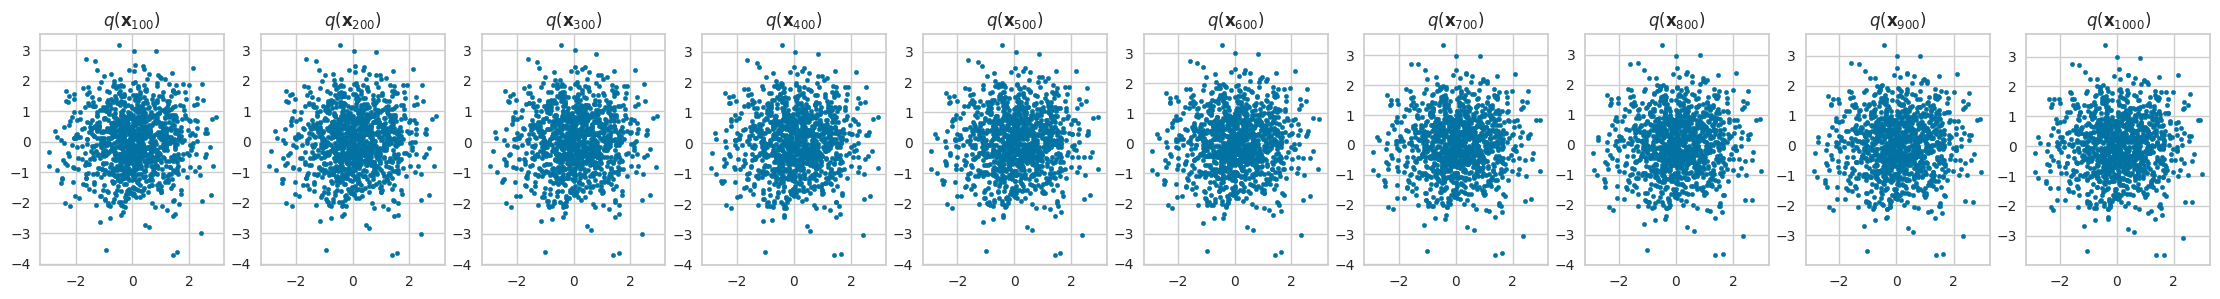

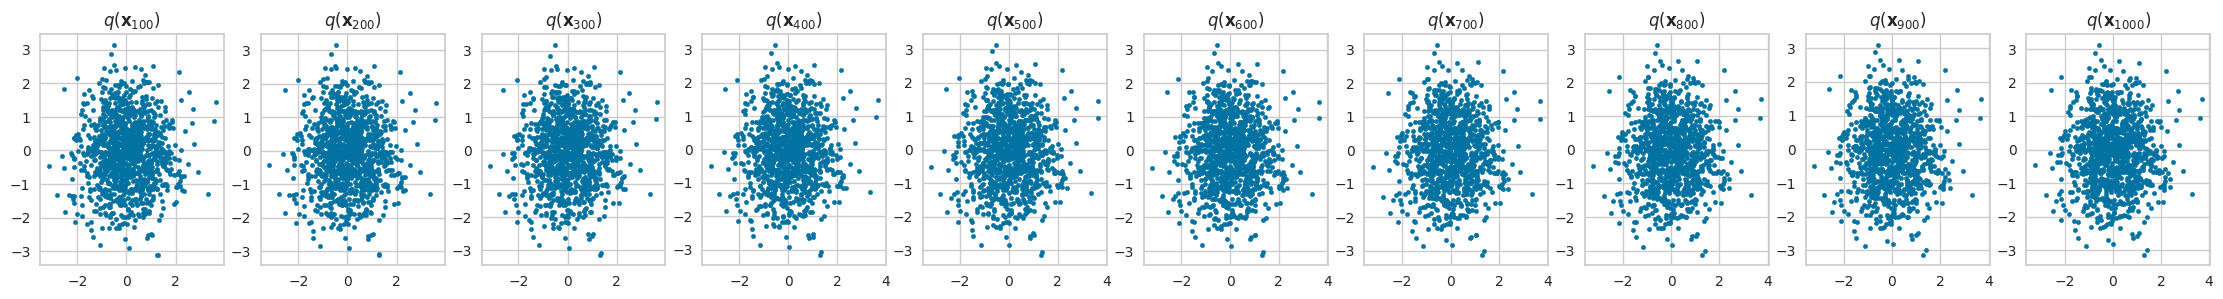

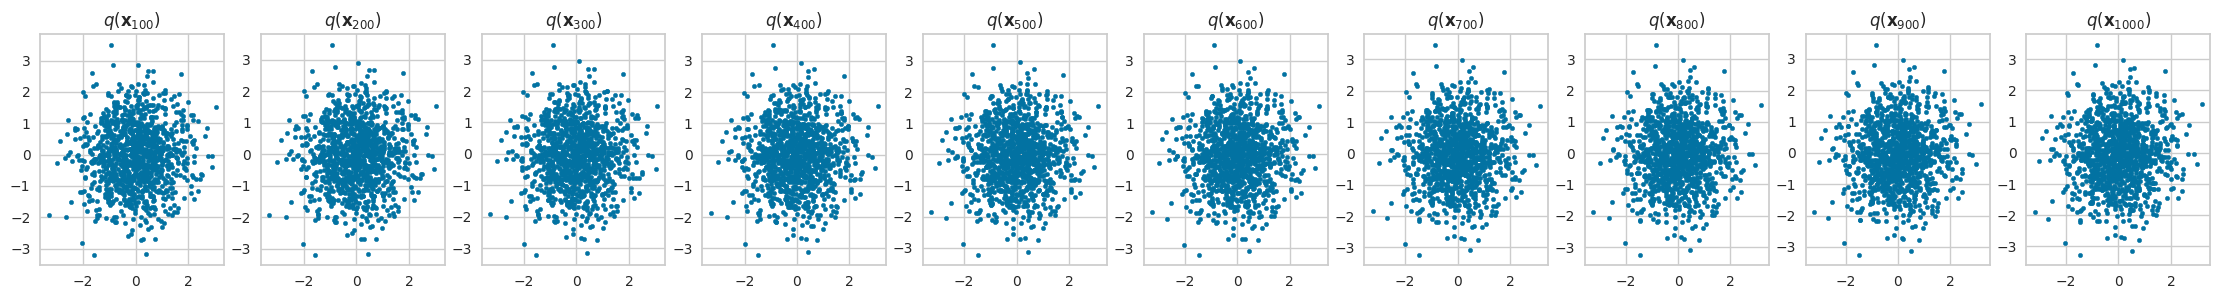

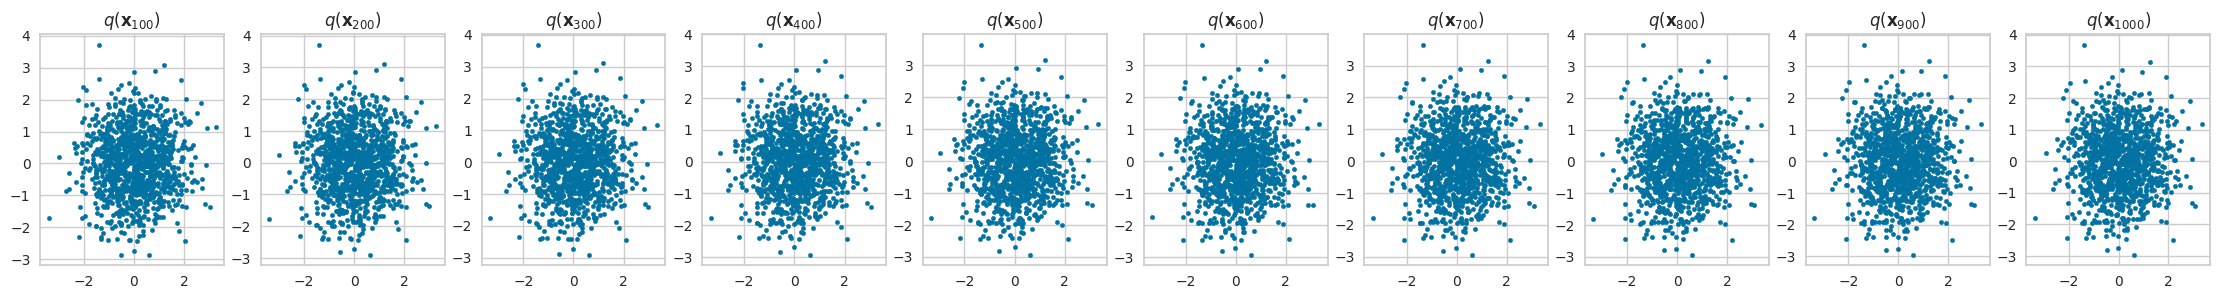

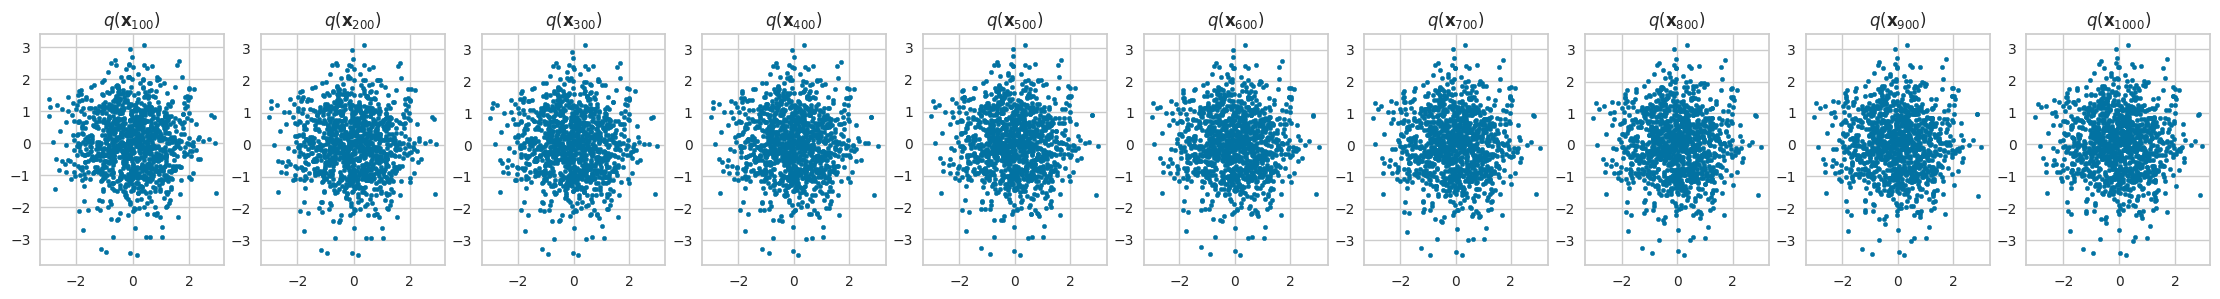

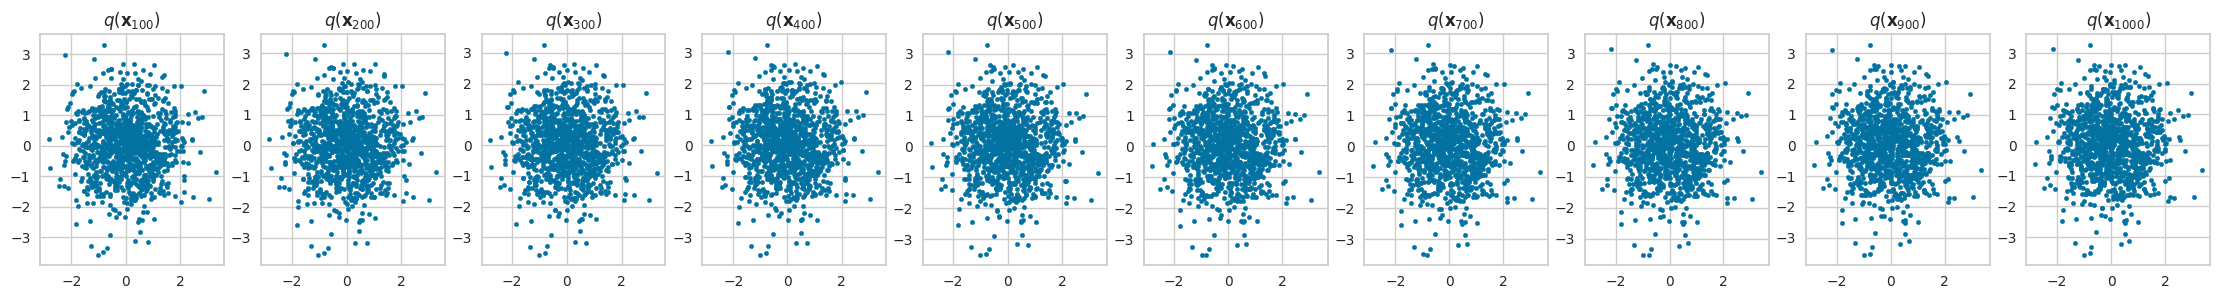

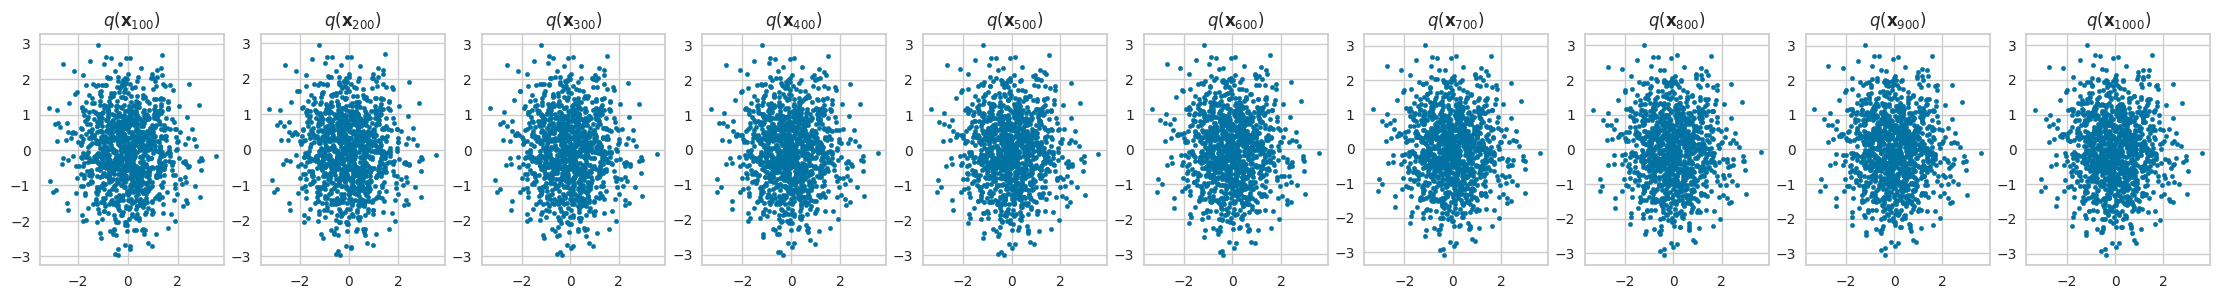

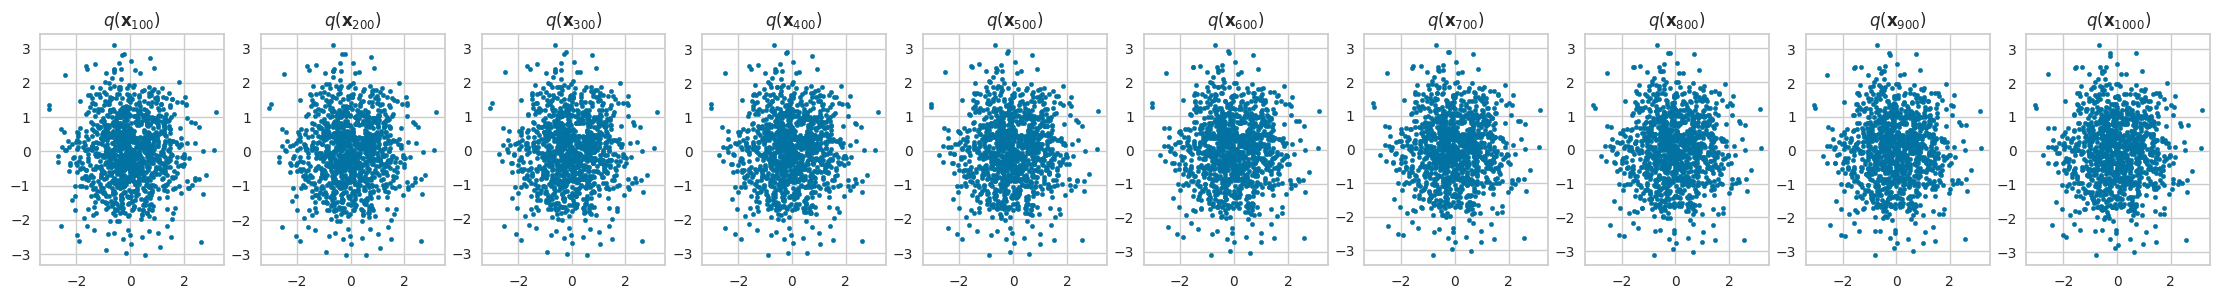

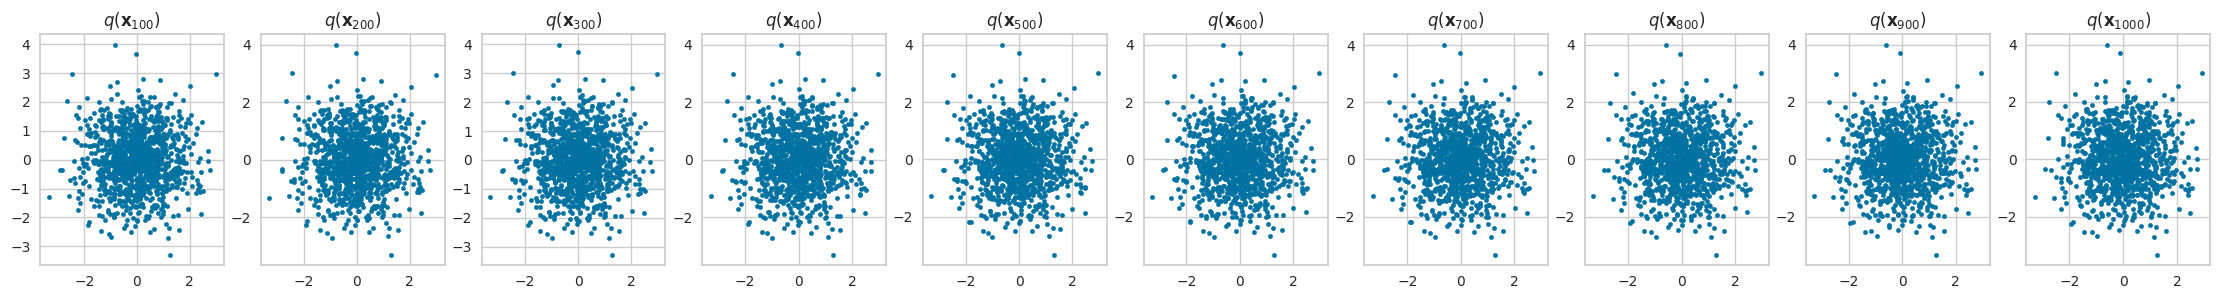

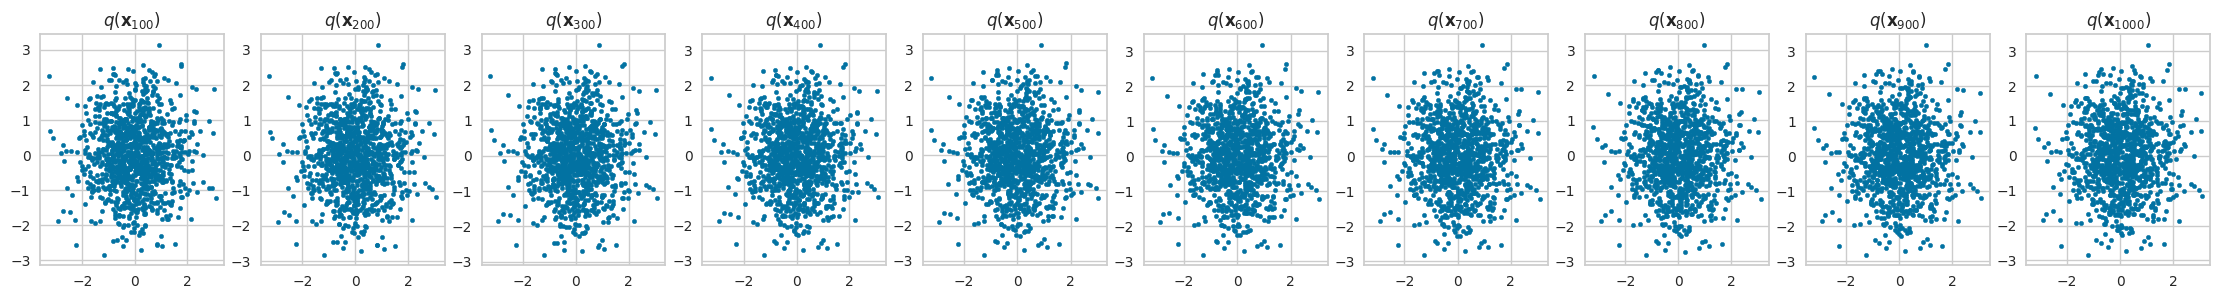

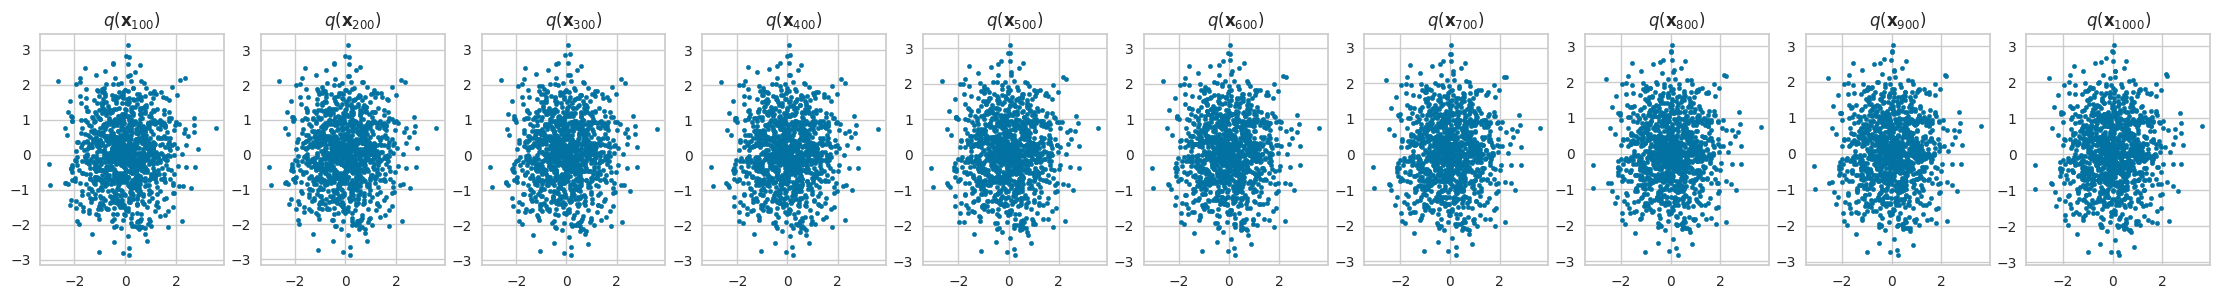

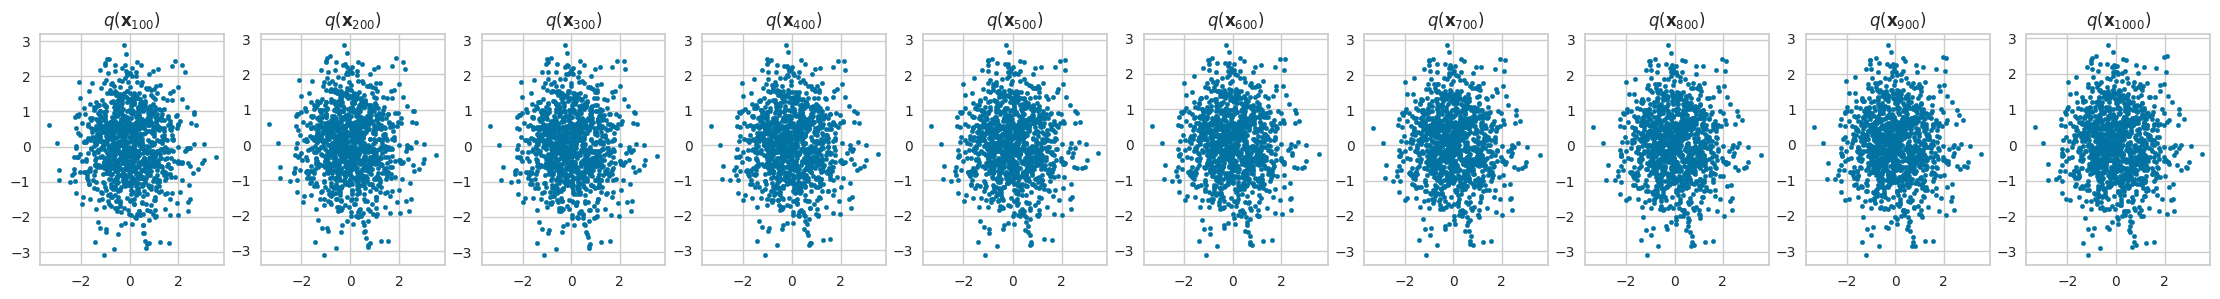

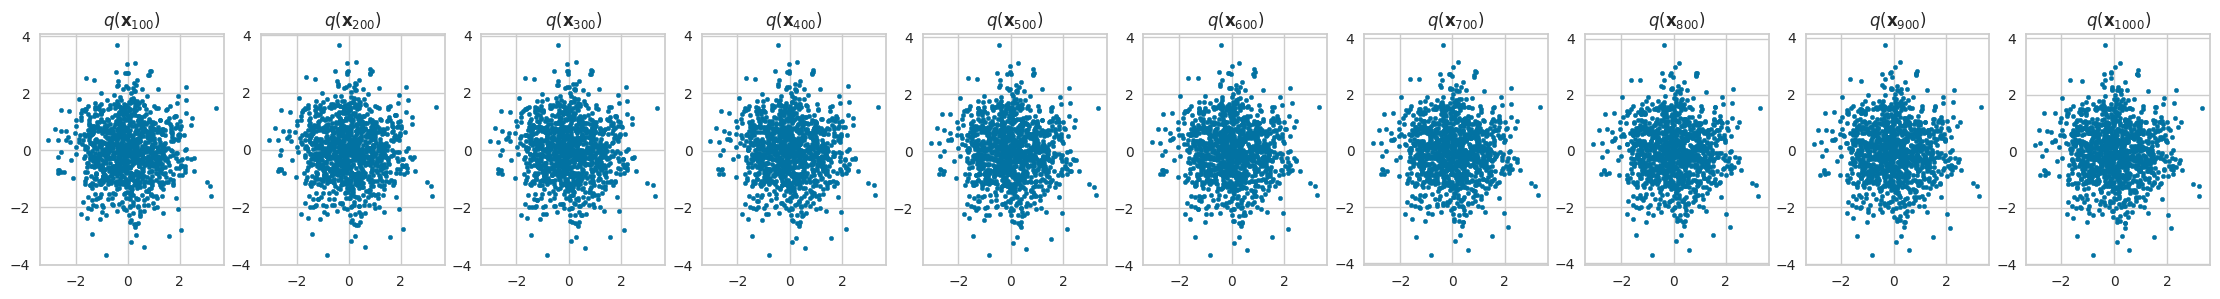

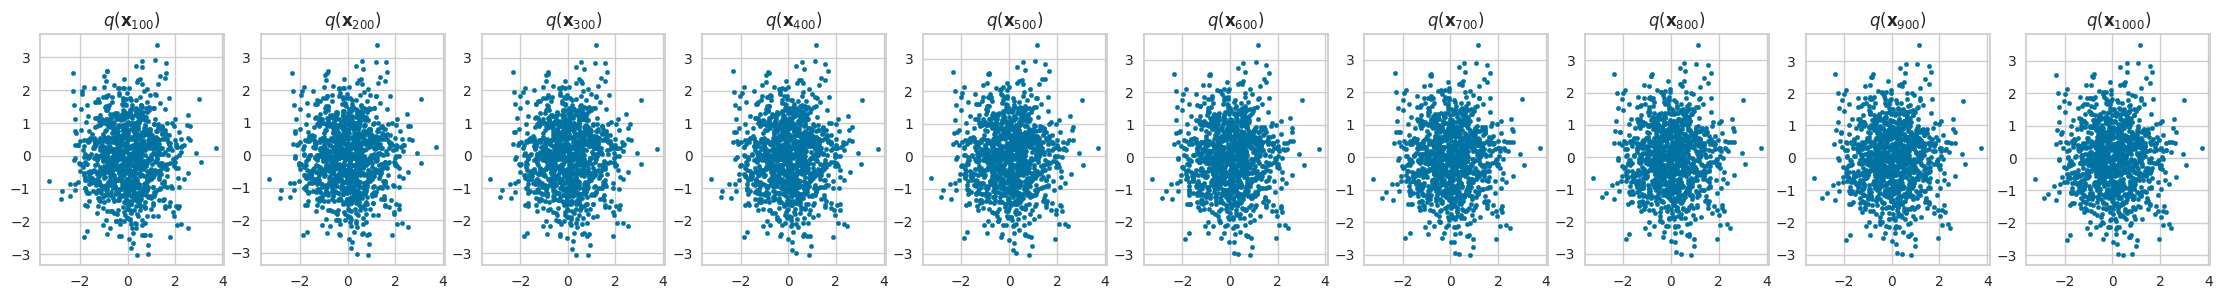

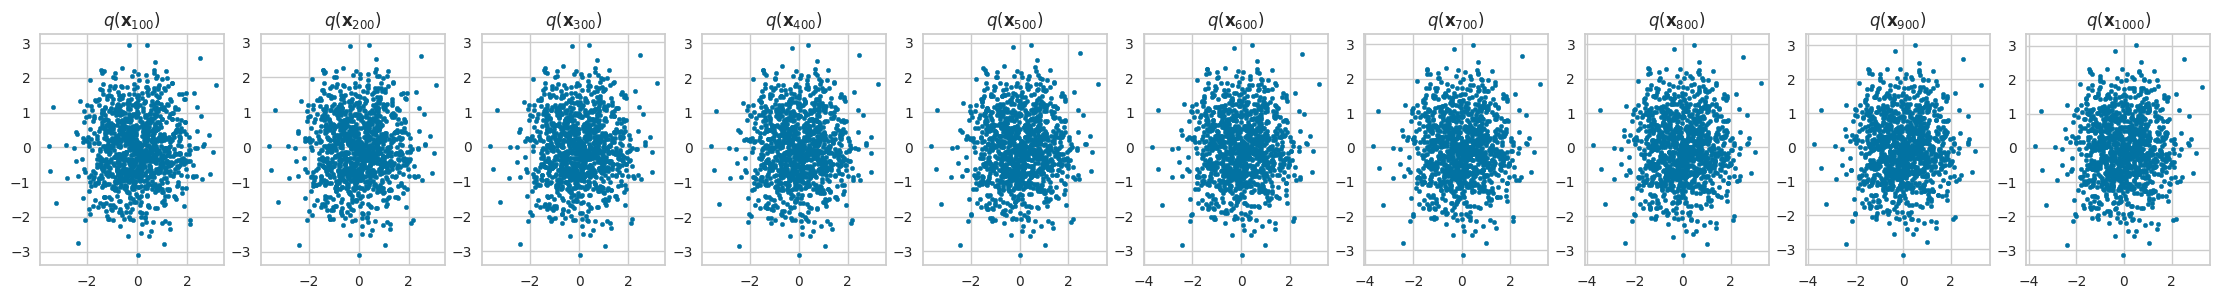

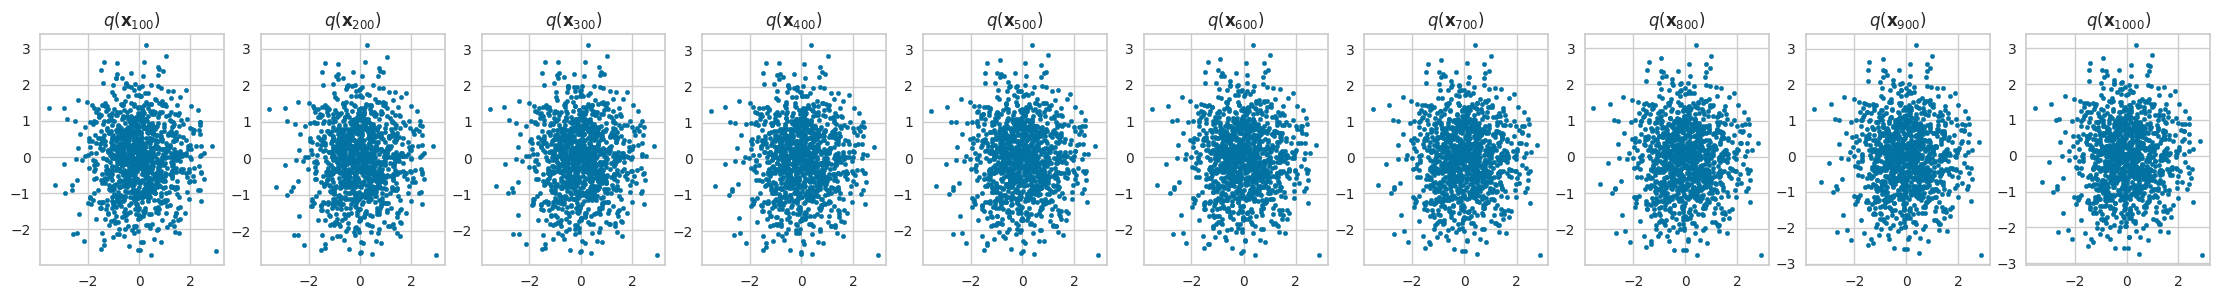

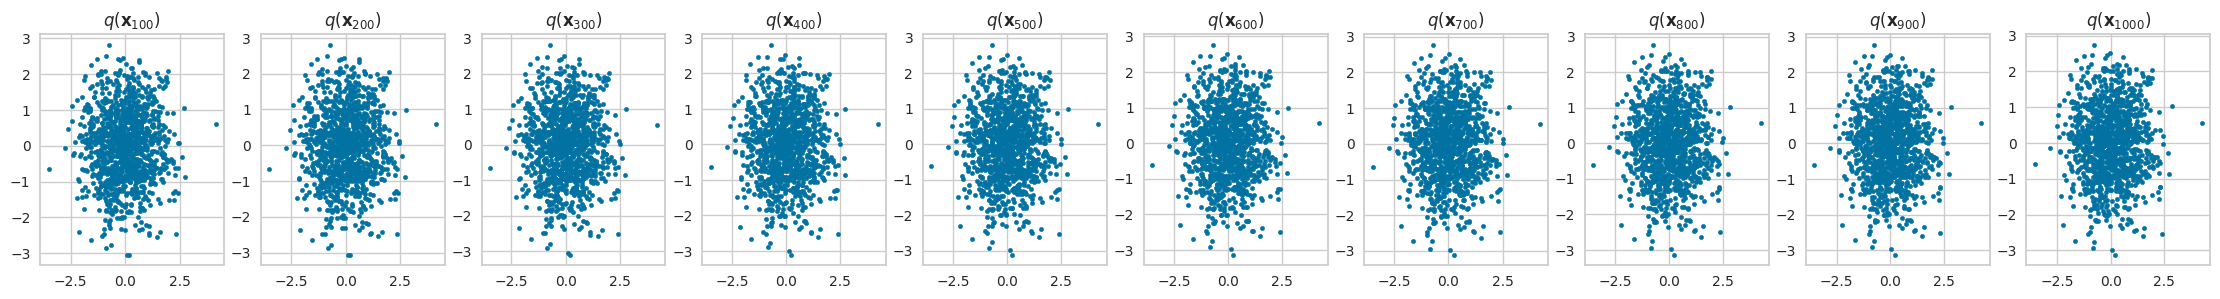

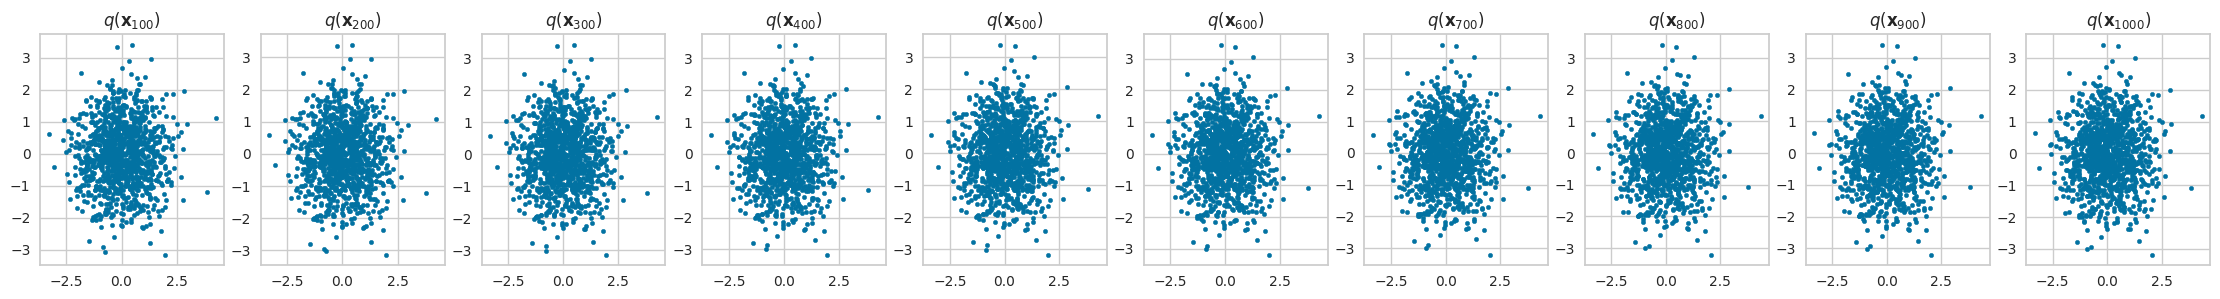

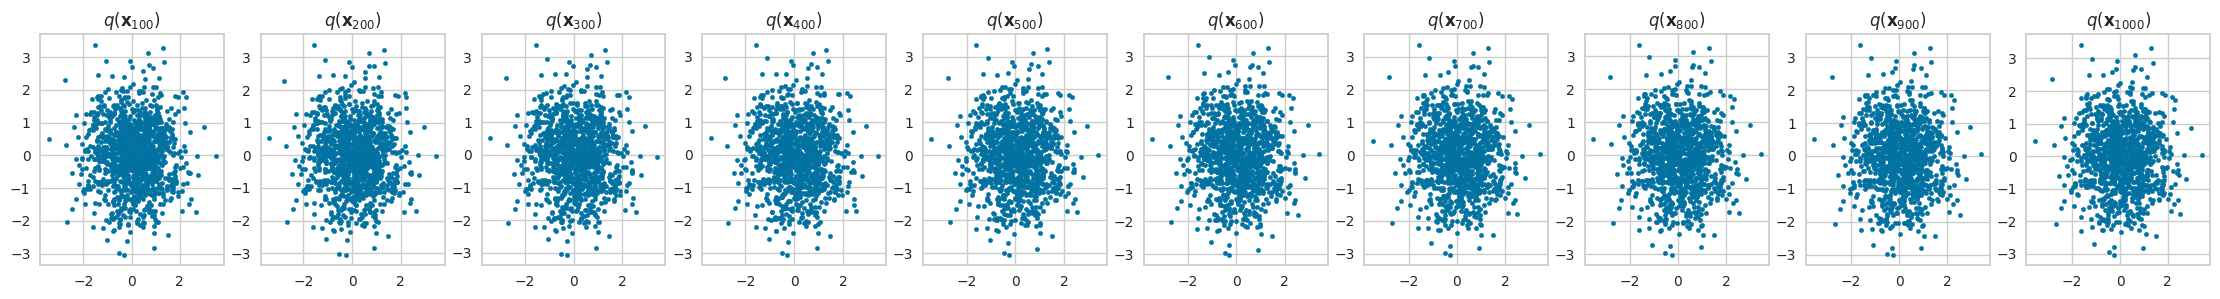

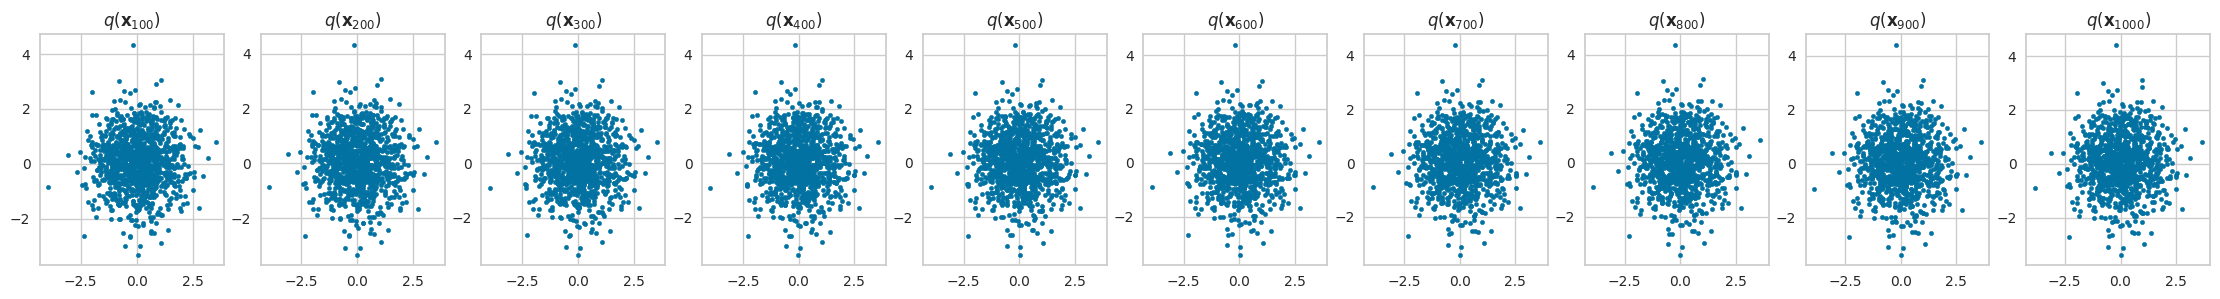

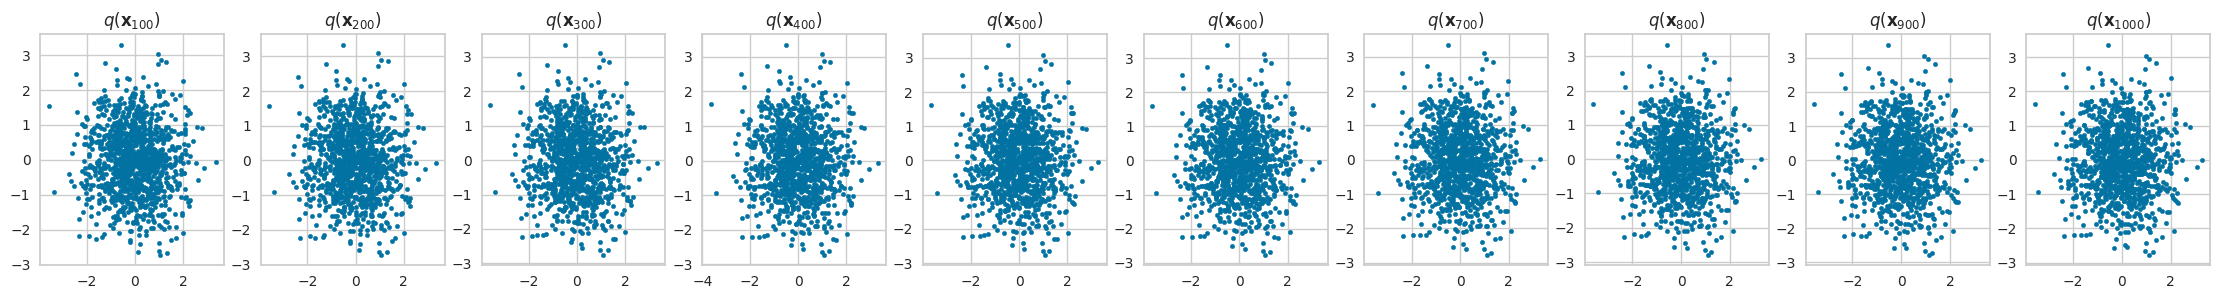

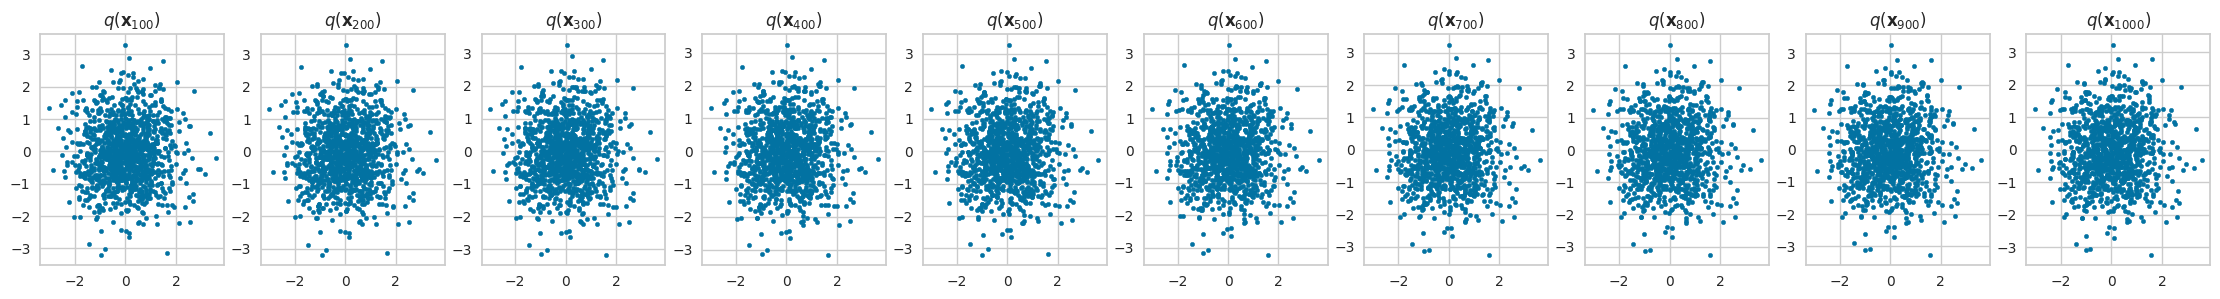

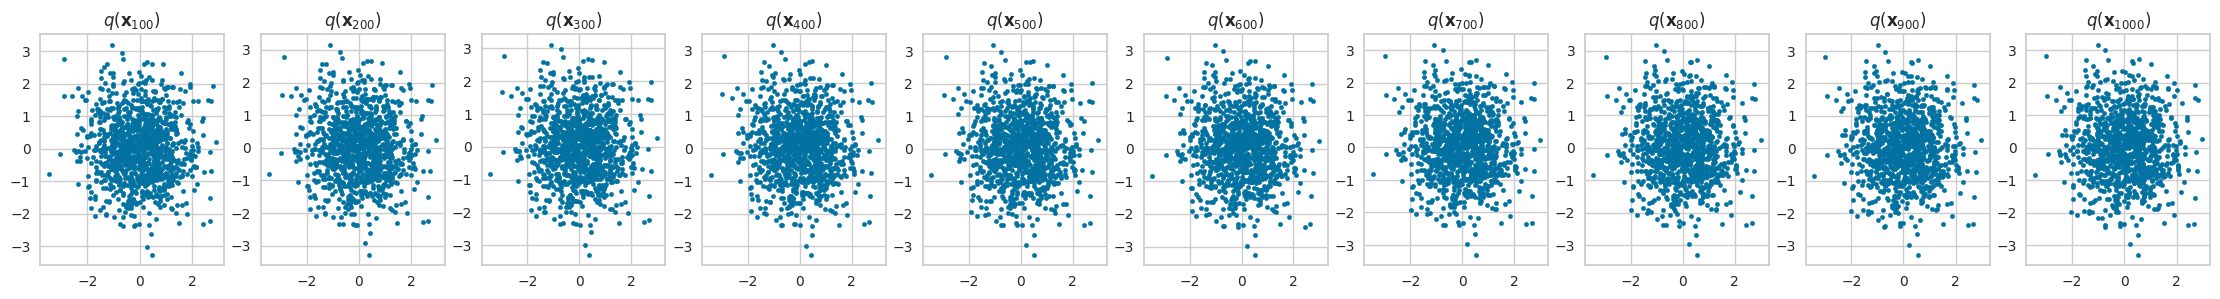

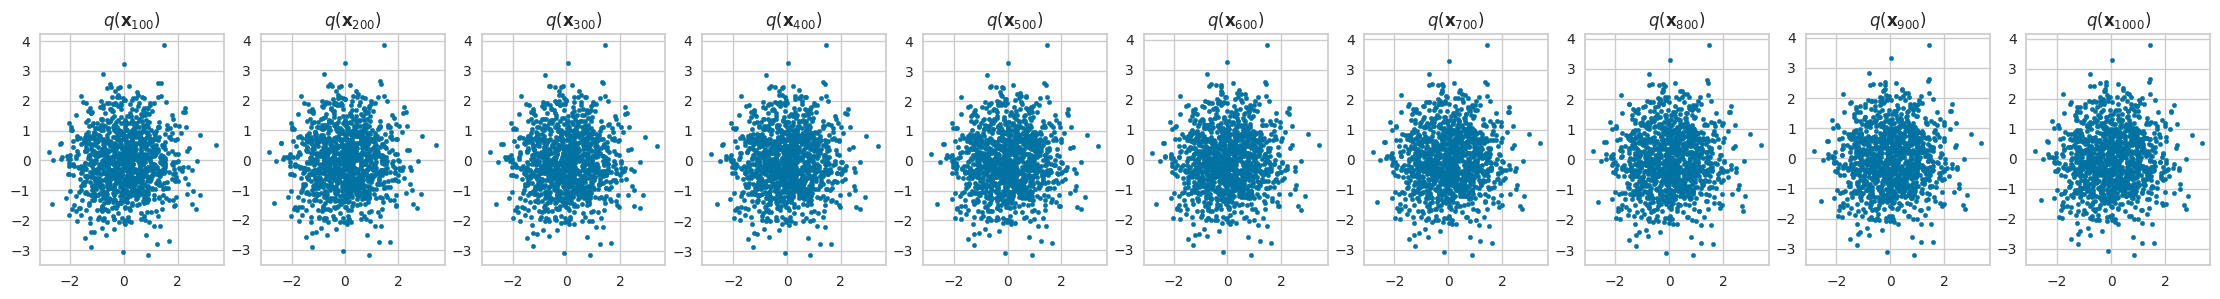

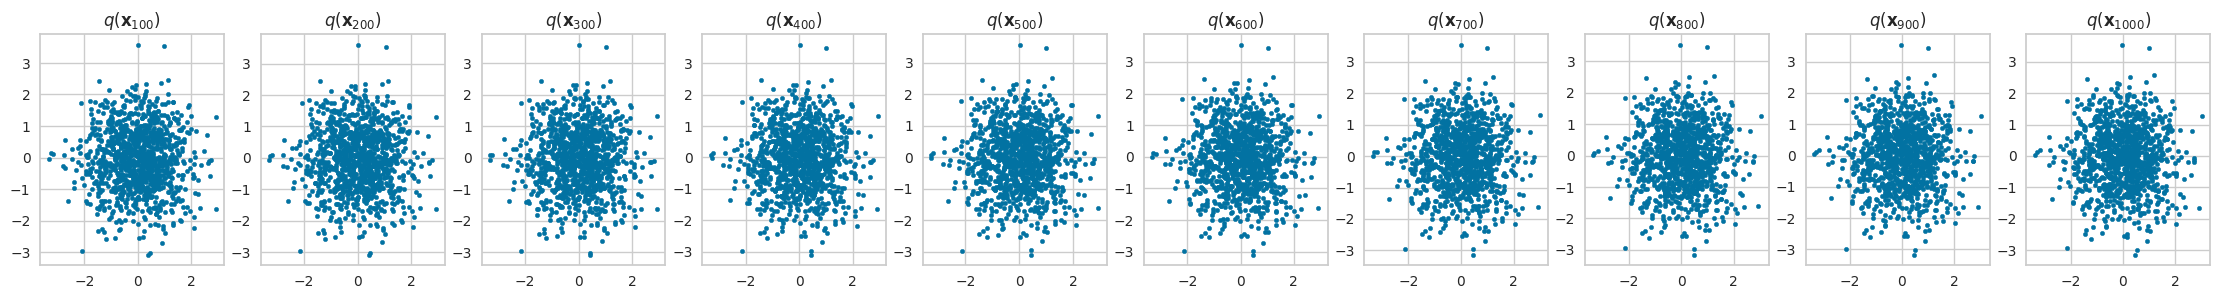

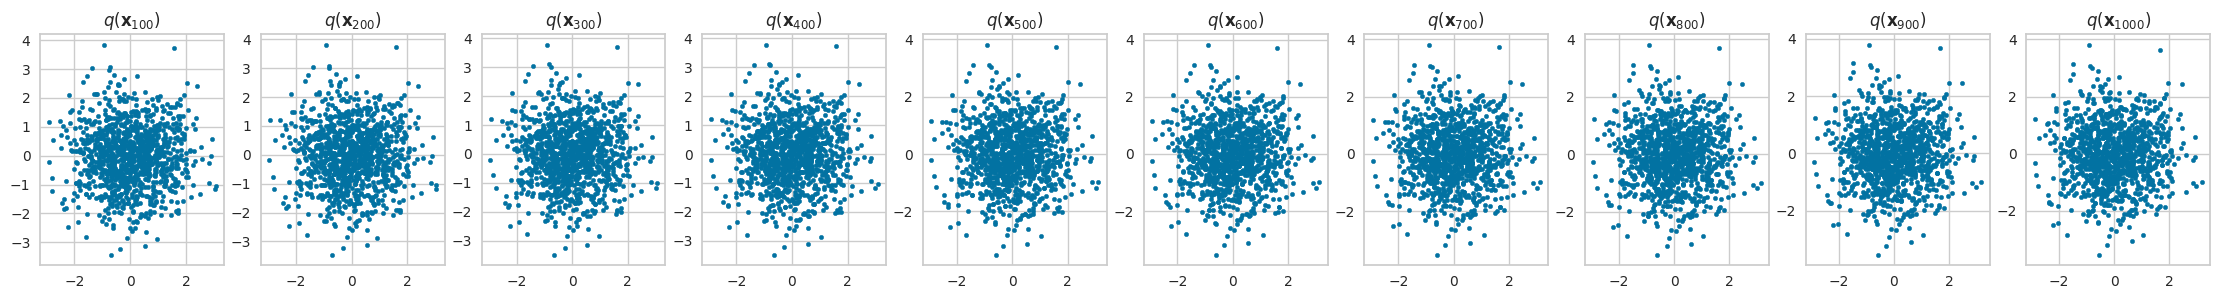

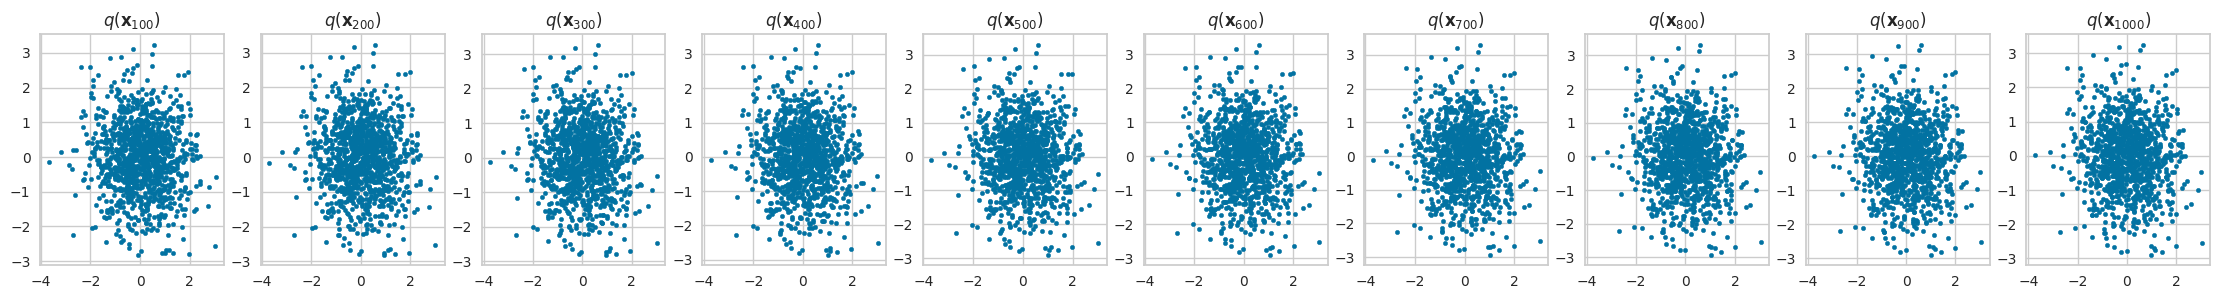

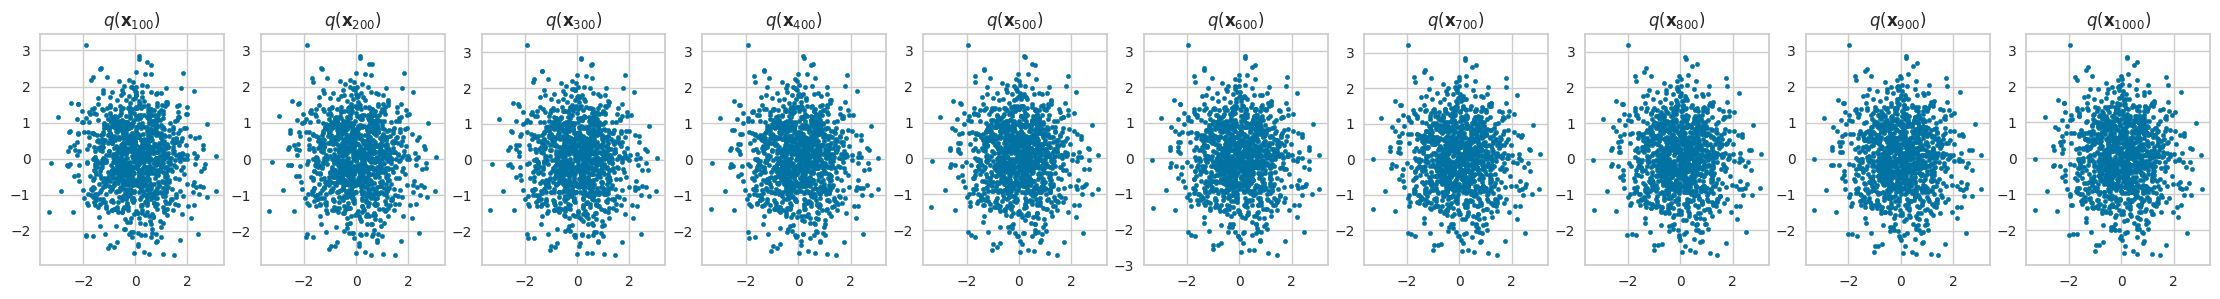

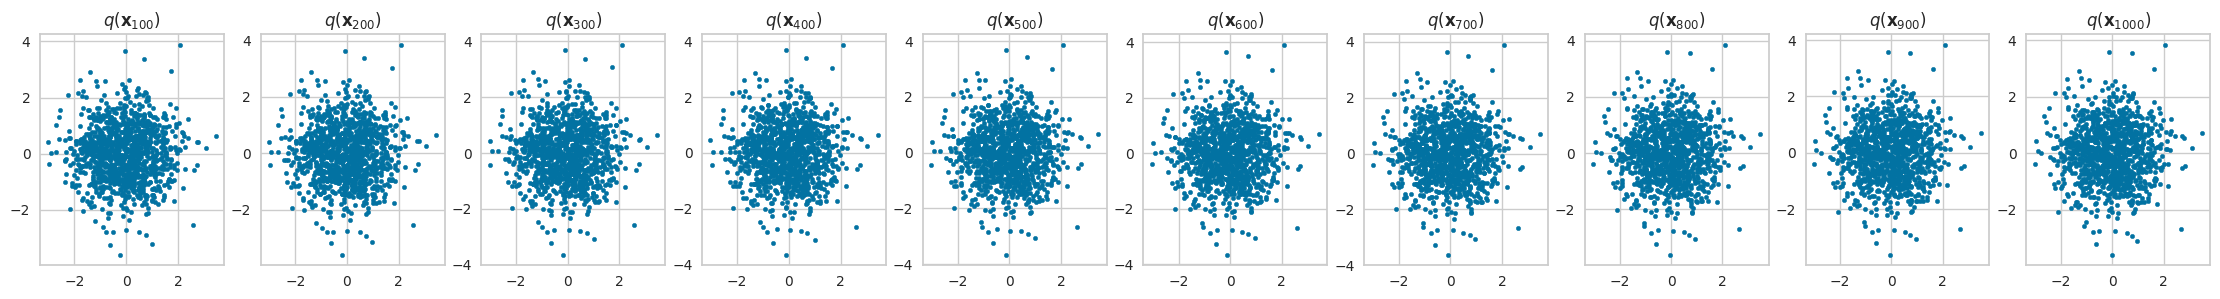

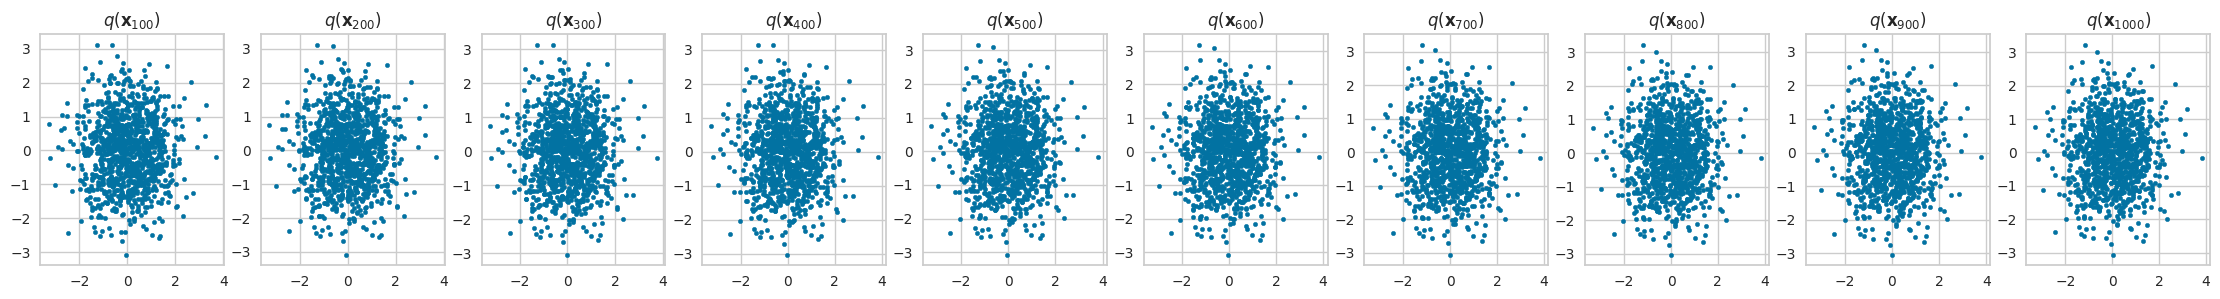

In [ ]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#dataset = torch.tensor(data.T).float()
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = X_train[0][7].shape[0]
for t in range(50001):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 200 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            #axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

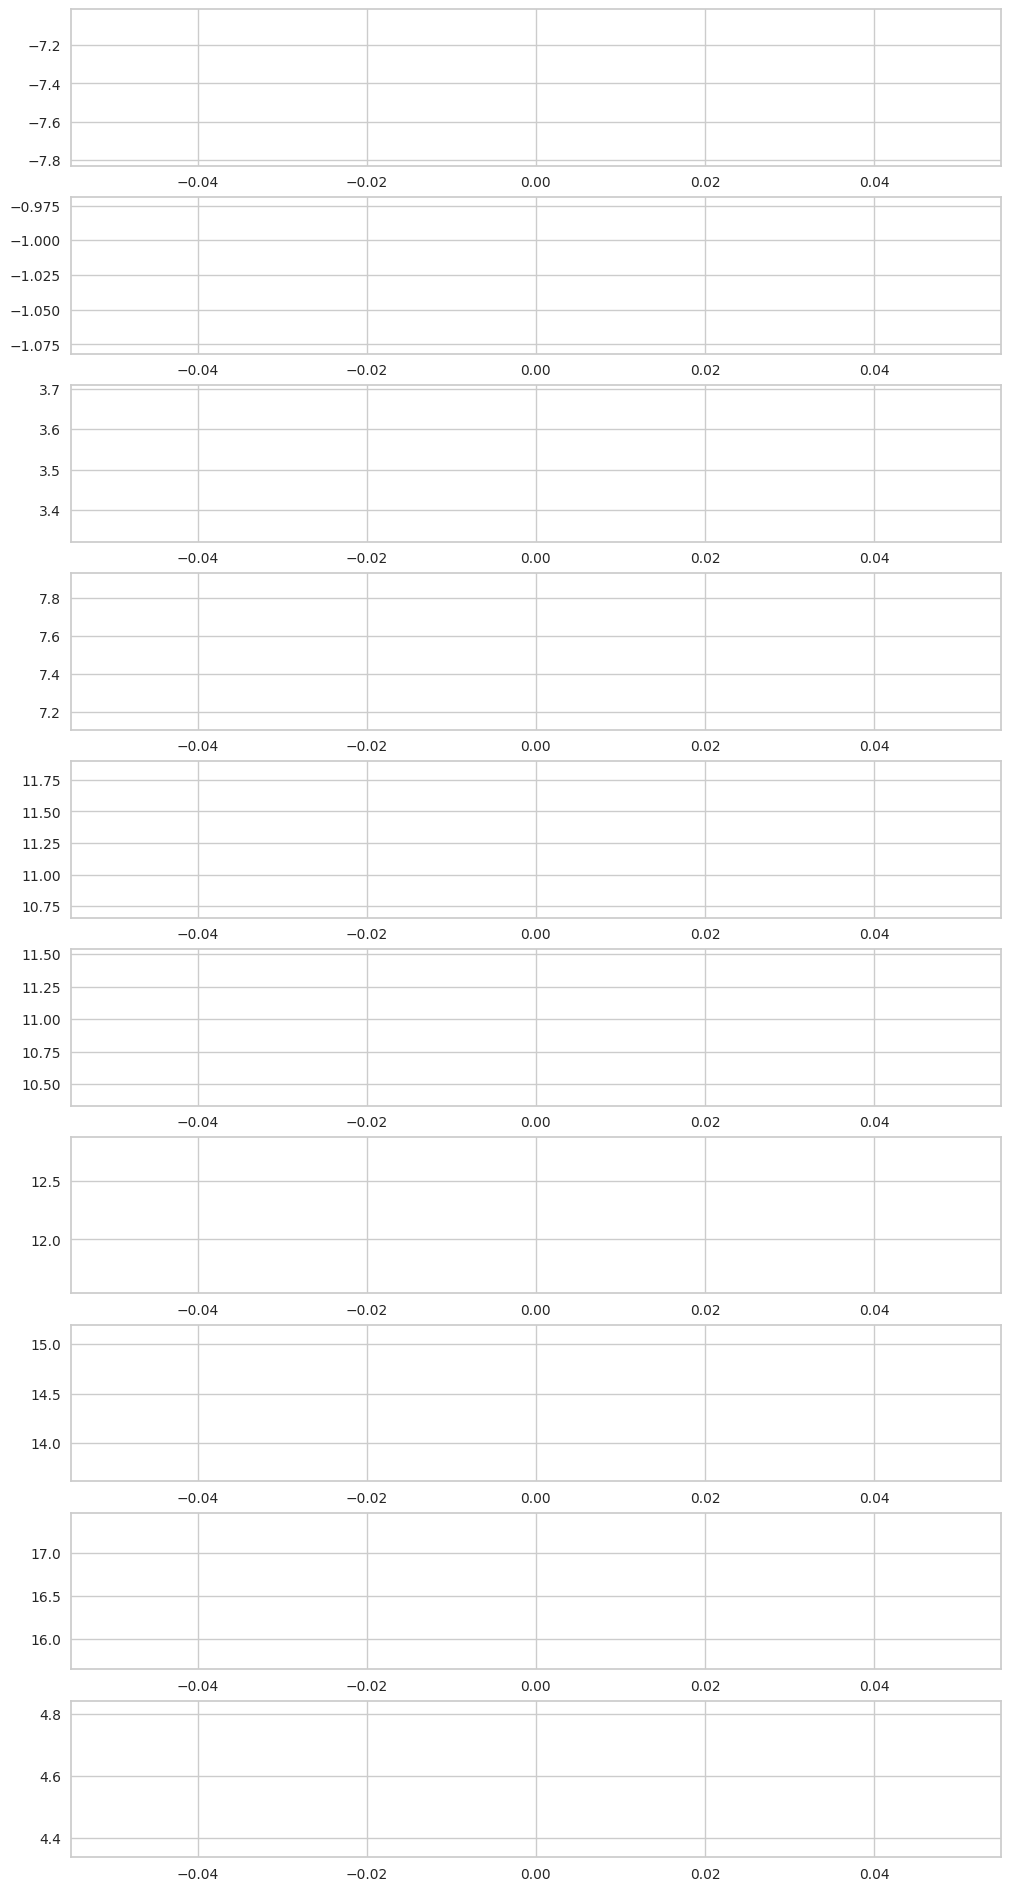

In [68]:
plt.figure(figsize=(12, 24))
for i in range(10):
    plt.subplot(10, 1, i+1)

    plt.plot(X_o1[i])

In [69]:
dataset = torch.tensor(X_o1)
len(X_o1)

1125

In [70]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

In [71]:
# Create schedule
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
# Fixed computation of variables for all timesteps
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)

In [74]:
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)

In [75]:
alphas_prod_p_sqrt = alphas_prod_p.sqrt()
def sample_continuous_noise_level(batch_size):
    """
    Samples continuous noise level.
    This is what makes WaveGrad different from other Denoising Diffusion Probabilistic Models.
    """
    t = np.random.choice(range(1, n_steps), size=batch_size)
    continuous_sqrt_alpha_cumprod = torch.FloatTensor(
        np.random.uniform(
            alphas_prod_p_sqrt[t-1],
            alphas_prod_p_sqrt[t],
            size=batch_size
        ))
    return continuous_sqrt_alpha_cumprod.unsqueeze(-1)


In [76]:
def q_sample(x_0, continuous_sqrt_alpha_cumprod=None, eps=None):
    batch_size = x_0.shape[0]
    if isinstance(eps, type(None)):
        continuous_sqrt_alpha_cumprod = sample_continuous_noise_level(batch_size)
        eps = torch.randn_like(x_0)
    # Closed form signal diffusion
    outputs = continuous_sqrt_alpha_cumprod.cuda(0) * x_0.cuda(0) + \
              (1 - continuous_sqrt_alpha_cumprod**2).sqrt().cuda(0) * eps.cuda(0)
    return outputs

def q_posterior(x_start, x, t):
    """ Computes reverse (denoising) process posterior q(y_{t-1}|y_0, y_t, x) """
    posterior_mean = posterior_mean_coef_1[t] * x_start + posterior_mean_coef_2[t] * x
    posterior_log_variance_clip = posterior_log_variance_clipped[t]
    return posterior_mean, posterior_log_variance_clip

In [77]:
n_steps = 1000
betas = make_beta_schedule(schedule='linear', n_timesteps=n_steps, start=1e-6, end=1e-2)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)

alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_prod_p_sqrt = alphas_prod_p.sqrt()
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
sqrt_recip_alphas_cumprod = (1 / alphas_prod).sqrt()
sqrt_alphas_cumprod_m1 = (1 - alphas_prod).sqrt() * sqrt_recip_alphas_cumprod
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

In [78]:
alphas_prod_p_sqrt.shape

torch.Size([1000])

In [79]:
def predict_start_from_noise(x, t, eps):
    """ Computes y_0 from given y_t and reconstructed noise. """
    return sqrt_recip_alphas_cumprod[t] * x - sqrt_alphas_cumprod_m1[t] * eps

def p_mean_variance(model, x, t, clip_denoised=True):
    """ Computes Gaussian transitions of Markov chain at step t """
    batch_size = x.shape[0]
    noise_level = torch.FloatTensor([alphas_prod_p_sqrt[t+1]]).repeat(batch_size, 1)
    # Infer noise, conditioned on continuous level
    eps_recon = model(x.cuda(0), noise_level.cuda(0))
    x_recon = predict_start_from_noise(x, t, eps_recon)
    # Output clipping in WaveGrad
    if clip_denoised:
        x_recon.clamp_(-1.0, 1.0)
    model_mean, posterior_log_variance = q_posterior(x_recon, x, t)
    return model_mean, posterior_log_variance

def p_sample(model, x, t):
    model_mean, model_log_variance = p_mean_variance(model, x, t)
    eps = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
    return model_mean + eps * (0.5 * model_log_variance).exp()

def p_sample_loop(model, shape):
    cur_x = torch.randn(shape).cuda(0)
    x_seq = [cur_x]
    for i in reversed(range(n_steps - 1)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

In [95]:
def compute_loss(model, x_0):
    # Sample continuous noise level
    batch_size = x_0.shape[0]

    continuous_sqrt_alpha_cumprod = sample_continuous_noise_level(batch_size)
    eps = torch.randn_like(x_0)
    # Diffuse the signal
    y_noisy = q_sample(x_0, continuous_sqrt_alpha_cumprod, eps)
    # Reconstruct the added noise
    eps_recon = model(y_noisy.cuda(0), continuous_sqrt_alpha_cumprod.cuda(0))
    print("eps_recon :{}".format(eps_recon.shape))
    print("eps :{}".format(eps.shape))
    loss = torch.nn.L1Loss()(eps_recon, eps)
    return loss

In [99]:
class PositionalEncoding(nn.Module):
    def __init__(self, n_channels):
        super(PositionalEncoding, self).__init__()
        self.n_channels = n_channels
        self.linear_scale = 5e3

    def forward(self, noise_level):
        if len(noise_level.shape) > 1:
            noise_level = noise_level.squeeze(-1)
        half_dim = self.n_channels // 2
        exponents = torch.arange(half_dim, dtype=torch.float32).to(noise_level) / float(half_dim)
        exponents = 1e-4 ** exponents
        exponents = self.linear_scale * noise_level.unsqueeze(1) * exponents.unsqueeze(0)
        return torch.cat([exponents.sin(), exponents.cos()], dim=-1)
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)

    def forward(self, x, y):
        out = self.lin(x)
        gamma = y
        out = gamma * out
        return out
class ConditionalConv1d(nn.Module):
    def __init__(self, **kwargs):
        super(ConditionalConv1d, self).__init__()
        self.conv1d = torch.nn.Conv1d(**kwargs)
        self.embedding = PositionalEncoding(kwargs.get('out_channels'))
        torch.nn.init.orthogonal_(self.conv1d.weight.data, gain=1)

    def forward(self, x, y):
        out = self.conv1d(x);
        gamma = self.embedding(y)
        return out * gamma.unsqueeze(-1)
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.conv1 = ConditionalConv1d(in_channels=1, out_channels=64, kernel_size=16, padding=8)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = ConditionalConv1d(in_channels=64, out_channels=64, kernel_size=16, padding=16, dilation=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=1, kernel_size=16, padding=16, dilation=2)
        self.lin1 = ConditionalLinear(133, 512)
        self.lin2 = nn.Linear(512, 128)

    def forward(self, x, y):
        x = x.unsqueeze(1)
        x = F.leaky_relu(self.bn1(self.conv1(x, y)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x, y)), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.squeeze(1)
        x = F.softplus(self.lin1(x, y))
        return self.lin2(x)

In [100]:
dataset = torch.tensor(X_o1).cuda(0)

In [101]:
# Create ADAM optimizer over our model
model = ConditionalModel(n_steps).cuda(0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Create EMA model
ema = EMA(0.9)
ema.register(model)
batch_size = 128
for t in range(5001):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices].cuda(0)
        # Compute the loss.
        loss = compute_loss(model, batch_x) #compute_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 200 == 0):
        print(loss)
        x_seq = p_sample_loop(model, [1, dataset.shape[1]])
        fig, axs = plt.subplots(1, 5, figsize=(28, 3))
        for i in range(1, 6):
            cur_x = x_seq[i * 10 - 1].detach()
            axs[i-1].plot(cur_x[0, :].cpu(), linewidth=2);
            #axs[i].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

eps_recon :torch.Size([128, 128])
eps :torch.Size([128])
eps_recon :torch.Size([128, 128])
eps :torch.Size([128])
eps_recon :torch.Size([128, 128])
eps :torch.Size([128])
eps_recon :torch.Size([128, 128])
eps :torch.Size([128])
eps_recon :torch.Size([128, 128])
eps :torch.Size([128])
eps_recon :torch.Size([128, 128])
eps :torch.Size([128])
eps_recon :torch.Size([128, 128])
eps :torch.Size([128])
eps_recon :torch.Size([128, 128])
eps :torch.Size([128])


/home/nutapolt/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (101x106 and 133x512)

In [51]:
config = nn.Module()
config.factors = [5, 5, 3, 2, 2]
config.upsampling_preconv_out_channels = 768
config.upsampling_out_channels = [512, 512, 256, 128, 128]
config.upsampling_dilations = [
            [1, 2, 1, 2],
            [1, 2, 1, 2],
            [1, 2, 4, 8],
            [1, 2, 4, 8],
            [1, 2, 4, 8]
        ]
config.downsampling_preconv_out_channels = 32
config.downsampling_out_channels = [128, 128, 256, 512]
config.downsampling_dilations = [[1, 2, 4], [1, 2, 4], [1, 2, 4], [1, 2, 4]]
config.n_mels = 80
class WaveGradNN(nn.Module):
    """
    WaveGrad is a fully-convolutional mel-spectrogram conditional
    vocoder model for waveform generation introduced in
    "WaveGrad: Estimating Gradients for Waveform Generation" paper (link: https://arxiv.org/pdf/2009.00713.pdf).
    The concept is built on the prior work on score matching and diffusion probabilistic models.
    Current implementation follows described architecture in the paper.
    """
    def __init__(self, config):
        super(WaveGradNN, self).__init__()
        # Building upsampling branch (mels -> signal)
        self.ublock_preconv = Conv1dWithInitialization(
            in_channels=config.n_mels,
            out_channels=config.upsampling_preconv_out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        upsampling_in_sizes = [config.upsampling_preconv_out_channels] \
            + config.upsampling_out_channels[:-1]
        self.ublocks = torch.nn.ModuleList([
            UpsamplingBlock(
                in_channels=in_size,
                out_channels=out_size,
                factor=factor,
                dilations=dilations
            ) for in_size, out_size, factor, dilations in zip(
                upsampling_in_sizes,
                config.upsampling_out_channels,
                config.factors,
                config.upsampling_dilations
            )
        ])
        self.ublock_postconv = Conv1dWithInitialization(
            in_channels=config.upsampling_out_channels[-1],
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=1
        )
        # Building downsampling branch (starting from signal)
        self.dblock_preconv = Conv1dWithInitialization(
            in_channels=1,
            out_channels=config.downsampling_preconv_out_channels,
            kernel_size=5,
            stride=1,
            padding=2
        )
        downsampling_in_sizes = [config.downsampling_preconv_out_channels] \
            + config.downsampling_out_channels[:-1]
        self.dblocks = torch.nn.ModuleList([
            DownsamplingBlock(
                in_channels=in_size,
                out_channels=out_size,
                factor=factor,
                dilations=dilations
            ) for in_size, out_size, factor, dilations in zip(
                downsampling_in_sizes,
                config.downsampling_out_channels,
                config.factors[1:][::-1],
                config.downsampling_dilations
            )
        ])

        # Building FiLM connections (in order of downscaling stream)
        film_in_sizes = [32] + config.downsampling_out_channels
        film_out_sizes = config.upsampling_out_channels[::-1]
        film_factors = [1] + config.factors[1:][::-1]
        self.films = torch.nn.ModuleList([
            FeatureWiseLinearModulation(
                in_channels=in_size,
                out_channels=out_size,
                input_dscaled_by=np.product(film_factors[:i+1])  # for proper positional encodings initialization
            ) for i, (in_size, out_size) in enumerate(
                zip(film_in_sizes, film_out_sizes)
            )
        ])

    def forward(self, mels, yn, noise_level):
        """
        Computes forward pass of neural network.
        :param mels (torch.Tensor): mel-spectrogram acoustic features of shape [B, n_mels, T//hop_length]
        :param yn (torch.Tensor): noised signal `y_n` of shape [B, T]
        :param noise_level (float): level of noise added by diffusion
        :return (torch.Tensor): epsilon noise
        """
        # Prepare inputs
        assert len(mels.shape) == 3  # B, n_mels, T
        yn = yn.unsqueeze(1)
        assert len(yn.shape) == 3  # B, 1, T

        # Downsampling stream + Linear Modulation statistics calculation
        statistics = []
        dblock_outputs = self.dblock_preconv(yn)
        scale, shift = self.films[0](x=dblock_outputs, noise_level=noise_level)
        statistics.append([scale, shift])
        for dblock, film in zip(self.dblocks, self.films[1:]):
            dblock_outputs = dblock(dblock_outputs)
            scale, shift = film(x=dblock_outputs, noise_level=noise_level)
            statistics.append([scale, shift])
        statistics = statistics[::-1]

        # Upsampling stream
        ublock_outputs = self.ublock_preconv(mels)
        for i, ublock in enumerate(self.ublocks):
            scale, shift = statistics[i]
            ublock_outputs = ublock(x=ublock_outputs, scale=scale, shift=shift)
        outputs = self.ublock_postconv(ublock_outputs)
        return outputs.squeeze(1)

In [60]:
class Conv1dWithInitialization(nn.Module):
    def __init__(self, **kwargs):
        super(Conv1dWithInitialization, self).__init__()
        self.conv1d = torch.nn.Conv1d(**kwargs)
        torch.nn.init.orthogonal_(self.conv1d.weight.data, gain=1)

    def forward(self, x):
        return self.conv1d(x)
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation):
        super(ConvolutionBlock, self).__init__()
        self.leaky_relu = torch.nn.LeakyReLU(0.2)
        self.convolution = Conv1dWithInitialization(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=dilation,
            dilation=dilation
        )

    def forward(self, x):
        outputs = self.leaky_relu(x)
        outputs = self.convolution(outputs)
        return outputs
class BasicModulationBlock(nn.Module):
    """
    Linear modulation part of UBlock, represented by sequence of the following layers:
        - Feature-wise Affine
        - LReLU
        - 3x1 Conv
    """
    def __init__(self, n_channels, dilation):
        super(BasicModulationBlock, self).__init__()
        self.featurewise_affine = FeatureWiseAffine()
        self.leaky_relu = torch.nn.LeakyReLU(0.2)
        self.convolution = Conv1dWithInitialization(
            in_channels=n_channels,
            out_channels=n_channels,
            kernel_size=3,
            stride=1,
            padding=dilation,
            dilation=dilation
        )

    def forward(self, x, scale, shift):
        outputs = self.featurewise_affine(x, scale, shift)
        outputs = self.leaky_relu(outputs)
        outputs = self.convolution(outputs)
        return outputs
class InterpolationBlock(nn.Module):
    def __init__(self, scale_factor, mode='linear', align_corners=False, downsample=False):
        super(InterpolationBlock, self).__init__()
        self.mode = mode
        self.downsample = downsample
        self.scale_factor = scale_factor
        self.align_corners = align_corners

    def forward(self, x):
        if (self.downsample):
            size = x.shape[-1] // self.scale_factor
        else:
            size = x.shape[-1] * self.scale_factor
        outputs = torch.nn.functional.interpolate(x,
            size = size, mode=self.mode,
            align_corners=self.align_corners,
            recompute_scale_factor=False
        )
        return outputs
class FeatureWiseLinearModulation(nn.Module):
    def __init__(self, in_channels, out_channels, input_dscaled_by):
        super(FeatureWiseLinearModulation, self).__init__()
        self.signal_conv = torch.nn.Sequential(*[
            Conv1dWithInitialization(
                in_channels=in_channels,
                out_channels=in_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            torch.nn.LeakyReLU(0.2)
        ])
        self.positional_encoding = PositionalEncoding(in_channels)
        self.scale_conv = Conv1dWithInitialization(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.shift_conv = Conv1dWithInitialization(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

    def forward(self, x, noise_level):

        outputs = self.signal_conv(x)
        outputs = outputs + self.positional_encoding(noise_level).unsqueeze(-1)
        scale, shift = self.scale_conv(outputs), self.shift_conv(outputs)
        return scale, shift
class FeatureWiseAffine(nn.Module):
    def __init__(self):
        super(FeatureWiseAffine, self).__init__()

    def forward(self, x, scale, shift):
        outputs = scale * x + shift
        return outputs

In [61]:
class UpsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, factor, dilations):
        super(UpsamplingBlock, self).__init__()
        self.first_block_main_branch = torch.nn.ModuleDict({
            'upsampling': torch.nn.Sequential(*[
                torch.nn.LeakyReLU(0.2),
                InterpolationBlock(
                    scale_factor=factor,
                    mode='linear',
                    align_corners=False
                ),
                Conv1dWithInitialization(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=3,
                    stride=1,
                    padding=dilations[0],
                    dilation=dilations[0]
                )
            ]),
            'modulation': BasicModulationBlock(
                out_channels, dilation=dilations[1]
            )
        })
        self.first_block_residual_branch = torch.nn.Sequential(*[
            Conv1dWithInitialization(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1
            ),
            InterpolationBlock(
                scale_factor=factor,
                mode='linear',
                align_corners=False
            )
        ])
        self.second_block_main_branch = torch.nn.ModuleDict({
            f'modulation_{idx}': BasicModulationBlock(
                out_channels, dilation=dilations[2 + idx]
            ) for idx in range(2)
        })

    def forward(self, x, scale, shift):
        # First upsampling residual block
        outputs = self.first_block_main_branch['upsampling'](x)
        outputs = self.first_block_main_branch['modulation'](outputs, scale, shift)
        outputs = outputs + self.first_block_residual_branch(x)

        # Second residual block
        residual = self.second_block_main_branch['modulation_0'](outputs, scale, shift)
        outputs = outputs + self.second_block_main_branch['modulation_1'](residual, scale, shift)
        return outputs
class DownsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, factor, dilations):
        super(DownsamplingBlock, self).__init__()
        in_sizes = [in_channels] + [out_channels for _ in range(len(dilations) - 1)]
        out_sizes = [out_channels for _ in range(len(in_sizes))]
        self.main_branch = torch.nn.Sequential(*([
            InterpolationBlock(
                scale_factor=factor,
                mode='linear',
                align_corners=False,
                downsample=True
            )
        ] + [
            ConvolutionBlock(in_size, out_size, dilation)
            for in_size, out_size, dilation in zip(in_sizes, out_sizes, dilations)
        ]))
        self.residual_branch = torch.nn.Sequential(*[
            Conv1dWithInitialization(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1
            ),
            InterpolationBlock(
                scale_factor=factor,
                mode='linear',
                align_corners=False,
                downsample=True
            )
        ])

    def forward(self, x):
        outputs = self.main_branch(x)
        outputs = outputs + self.residual_branch(x)
        return outputs

In [62]:
# Create ADAM optimizer over our model
model = WaveGradNN(config).cuda(0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Create EMA model
ema = EMA(0.9)
ema.register(model)
batch_size = 128
for t in range(5001):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices].cuda(0)
        # Compute the loss.
        loss = compute_loss(model, batch_x) #compute_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 200 == 0):
        print(loss)
        x_seq = p_sample_loop(model, [1, dataset.shape[1]])
        fig, axs = plt.subplots(1, 5, figsize=(28, 3))
        for i in range(1, 6):
            cur_x = x_seq[i * 10 - 1].detach()
            axs[i-1].plot(cur_x[0, :].cpu(), linewidth=2);
            #axs[i].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

TypeError: forward() missing 1 required positional argument: 'noise_level'

In [57]:
noise_level = torch.FloatTensor([alphas_prod_p_sqrt[t+1]]).repeat(batch_size, 1)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1

OSError: cannot load library 'libsndfile.so': libsndfile.so: cannot open shared object file: No such file or directory